### Import libraries

In [76]:
from pyDOE import *
import pandas as pd
import os
import matplotlib.pyplot as plt
from xml.etree.ElementTree import tostring
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.stats import skew
from scipy.stats import kurtosis
from hurst import compute_Hc
from statsmodels.stats.diagnostic import het_arch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from cProfile import label
import seaborn as sns

### Define function to calculate the Hurst exponent

In [77]:
# Code from https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e

def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    
    return reg[0]

### Sample parameter values using Latin hypercube sampling -> Create X

In [78]:
# Code from https://pythonhosted.org/pyDOE/randomized.html

nParamsLHS = 11
nSamples = 1000
LHS_seed = 123

np.random.seed(LHS_seed)
parameters = lhs(nParamsLHS, samples=nSamples, criterion='center')
parameters_df = pd.DataFrame(parameters)
parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset']
#parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset', 'startSeed']

output_file = "LHS_parameters_" + str(nParamsLHS) + "_" + str(nSamples) + "_center_seed" + str(LHS_seed) + ".csv"
java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\in\params\TrendValueVarAbmSurrogate\\'
parameters_df.to_csv(java_folder + output_file)

print(parameters_df.head())

   nTrends  nFunds     liq  sigma_P  sigma_V  maShortMin  maLongMin  \
0   0.8195  0.9755  0.8185   0.0235   0.1995      0.2725     0.6065   
1   0.0175  0.1985  0.8225   0.8875   0.5255      0.7635     0.7035   
2   0.7025  0.8945  0.6355   0.2885   0.2825      0.1665     0.6765   
3   0.2275  0.4885  0.1345   0.8595   0.5565      0.9625     0.7925   
4   0.6445  0.2825  0.3485   0.7365   0.2925      0.6635     0.0985   

   bcTicksMin  entryThMin  exitThdMin  valueOffset  
0      0.9095      0.6065      0.7005       0.6815  
1      0.3955      0.3825      0.5265       0.4545  
2      0.1315      0.2985      0.2535       0.7185  
3      0.0795      0.2815      0.5555       0.9485  
4      0.1925      0.9805      0.9085       0.2295  


### Read CSV file of prices generated in Java

In [81]:
java_seed = 965
output_file = "java_price_timeseries_" + str(nParamsLHS) + "_" + str(nSamples) + "_seed" + str(java_seed) + ".csv"
java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\nSamples_' + str(nSamples) + '\\'
print(java_folder + output_file)

ABM_prices_df = pd.read_csv(java_folder + output_file)

# Delete column of ticks, as it has the same values than the index
ABM_prices_df = ABM_prices_df.drop(['tick'], axis=1)

# Extract number of runs and ticks 
nTicks = ABM_prices_df.shape[0]
nRuns = ABM_prices_df.shape[1]

print(nTicks)
print(nRuns)

C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\nSamples_1000\java_price_timeseries_11_1000_seed965.csv
4000
1000


### Calculate returns

In [82]:
# Calculate returns
ABM_returns_df = ABM_prices_df.pct_change()
ABM_returns_df = ABM_returns_df.drop(ABM_returns_df.index[0])  # Delete first row (= NaN)

# Transpose the dataframe to have each instance of return series in a row, as is the usual practice in ML input datasets
ABM_returns_df = ABM_returns_df.transpose() 

### Analyse the stylised facts of the return time series

In [83]:
# Create a dataframe to store the stylised facts
SF_df = pd.DataFrame()

# ------- Excess kurtosis of returns ------- #
SF_df['Kurtosis_ret'] = kurtosis(ABM_returns_df, axis=1, fisher=True, bias=False)

# ------- Hurst exponent of returns ------- #
Hurst_max_lag = 20   # "The default value of 20 is based on Matlab’s implementation of the Hurst function" 
                     # (https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e)
Hurst_vector_ret = np.zeros(nRuns)  # Vector to store the Hurst exponent of the different return time series
for i in range(0, nRuns):
	H = get_hurst_exponent(ABM_prices_df.iloc[:,i].values, Hurst_max_lag)
	Hurst_vector_ret[i] = H

SF_df['Hurst_ret'] = Hurst_vector_ret

# ------- Engle's ARCH test for volatility ------- #

pval_Lagrange = np.zeros(nRuns)
pval_Ftest = np.zeros(nRuns)
for i in range(0, nRuns):
	etest = het_arch(ABM_returns_df.iloc[i], nlags=5)
	pval_Lagrange[i] = np.round(etest[1], 4)  # Lagrange multiplier test
	#pval_Ftest[i] = np.round(etest[3], 4)    # F-test (I finally do not consider this as results are very similar to those from the Lagrange test)

SF_df['pval_ARCH_test_vol'] = pval_Lagrange

# ------- Skewness of volatility (=returns^2) ------- #
SF_df['Skewness_vol'] = skew(pow(ABM_returns_df,2), axis=1, bias=False)


     Kurtosis_ret  Hurst_ret  pval_ARCH_test_vol  Skewness_vol
0       14.278619   0.440119                 0.0      7.768469
1        0.209100   0.463651                 0.0      3.089125
2        2.586972   0.449255                 0.0      4.702143
3        0.241397   0.443621                 0.0      2.942110
4        0.377213   0.488137                 0.0      3.261138
..            ...        ...                 ...           ...
995      0.231018   0.501241                 0.0      2.965821
996      1.122614   0.516059                 0.0      4.991628
997      1.158779   0.526930                 0.0      4.438324
998      2.159170   0.492060                 0.0      6.040792
999      1.228429   0.514711                 0.0      4.400472

[1000 rows x 4 columns]


### Check if the stylised facts are replicated -> Create Y

* Excess kurtosis of returns should be positive --> Fat tails
* Hurst exponent of returns should lie around 0.5 --> Lack of return autocorrelation
* p-value of the ARCH test of returns should be smaller than 0.01 (and so null hypothesis is rejected) --> Volatility clustering
* Skewness of volatility should be positive --> Volatility skewness

In [84]:
SF_df['SF_satisfied'] = 0

for i in range(0, nRuns):
	if (SF_df.at[i,'Kurtosis_ret']>0 and SF_df.at[i,'Hurst_ret']>0.45 and SF_df.at[i,'Hurst_ret']<0.55 and SF_df.at[i,'pval_ARCH_test_vol']<0.01 and SF_df.at[i,'Skewness_vol']>0):
		SF_df.at[i,'SF_satisfied'] = 1

		
print(SF_df[0:50])

SF_df['SF_satisfied'].value_counts()

    Kurtosis_ret  Hurst_ret  pval_ARCH_test_vol  Skewness_vol  SF_satisfied
0      14.278619   0.440119                 0.0      7.768469             0
1       0.209100   0.463651                 0.0      3.089125             1
2       2.586972   0.449255                 0.0      4.702143             0
3       0.241397   0.443621                 0.0      2.942110             0
4       0.377213   0.488137                 0.0      3.261138             1
5       9.043344   0.460427                 0.0      6.565425             1
6       0.861091   0.473961                 0.0      4.104223             1
7       3.123867   0.465319                 0.0      5.737194             1
8       4.618333   0.412913                 0.0      8.888943             0
9       0.500914   0.477105                 0.0      3.286666             1
10      0.337314   0.508385                 0.0      3.656354             1
11      0.124446   0.504021                 0.0      3.290275             1
12      7.71

1    696
0    304
Name: SF_satisfied, dtype: int64

### Split X,Y into training and test sets

In [85]:
test_size = 0.2

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(parameters_df, SF_df['SF_satisfied'], test_size = test_size, random_state = 5)  # Set random state for reproducibility

     nTrends  nFunds     liq  sigma_P  sigma_V  maShortMin  maLongMin  \
40    0.5915  0.0315  0.0945   0.0695   0.5705      0.1155     0.9575   
977   0.3305  0.2735  0.1365   0.3715   0.1965      0.9095     0.3085   
829   0.9035  0.5715  0.3305   0.0145   0.0385      0.6465     0.9715   
973   0.4225  0.8075  0.0865   0.2205   0.6355      0.7385     0.4575   
874   0.8915  0.3725  0.9415   0.7465   0.4785      0.5585     0.8575   
475   0.2895  0.4555  0.7885   0.6475   0.0375      0.2885     0.2555   
839   0.0695  0.8935  0.2515   0.1635   0.0575      0.5055     0.7235   
665   0.4615  0.8645  0.1655   0.2085   0.2315      0.8575     0.3855   
199   0.3275  0.4745  0.0675   0.4045   0.0285      0.5925     0.7185   
196   0.9515  0.8865  0.3515   0.7505   0.2265      0.2765     0.2405   

     bcTicksMin  entryThMin  exitThdMin  valueOffset  
40       0.9245      0.9265      0.0305       0.7915  
977      0.7585      0.2865      0.2045       0.1235  
829      0.8435      0.8375    

### Implement classification methods

In [86]:
seed = 101        # Seed for model creation, for later replicability
num_folds = 10    # Number of folds for cross-validation
cv_scoring = 'accuracy'   # Scoring metric used in cross-validation

#### Create list of models (using default value of hyperparameters)

In [88]:
models_default_params = []
models_default_params.append(('LR', LogisticRegression()))
models_default_params.append(('BAYES', GaussianNB()))
models_default_params.append(('KNN', KNeighborsClassifier()))
models_default_params.append(('DT', DecisionTreeClassifier(random_state=seed)))
models_default_params.append(('RF', RandomForestClassifier(random_state=seed)))
models_default_params.append(('SVM', SVC(random_state=seed, probability=True)))
models_default_params.append(('MLP', MLPClassifier(random_state=seed)))

Once we have selected all the models, we loop over each of them. First we run the model on the entire training and then on the testing dataset.

In [89]:
names = []
kfold_accuracy = []
kfold_timing = []
train_accuracy = []
train_timing = []
test_accuracy = []
test_timing = []

#for name, model in models_tuned:
for name, model in models_default_params:
    names.append(name)
    
    # Accuracy in k-fold cross-validation
    start_time = time.perf_counter()
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=cv_scoring)
    kfold_accuracy.append(cv_results)
    end_time = time.perf_counter()
    kfold_timing.append(end_time-start_time)    

    # Accuracy for the training data
    start_time = time.perf_counter()
    res = model.fit(X_train, y_train)
    train_result = accuracy_score(res.predict(X_train), y_train)
    train_accuracy.append(train_result)
    end_time = time.perf_counter()
    train_timing.append(end_time-start_time) 
    
    # Accuracy for the test data
    start_time = time.perf_counter()
    y_pred = res.predict(X_test)
    test_result = accuracy_score(y_pred, y_test)
    test_accuracy.append(test_result)
    end_time = time.perf_counter()
    test_timing.append(end_time-start_time) 

    msg = "%s: %f %f" % (name, train_result, test_result)
    print(msg)

    #print(confusion_matrix(y_pred, y_test))
    #print(classification_report(y_pred, y_test))

print("train accuracy:", train_accuracy)
print("test accuracy:", test_accuracy)
print("train timing:", train_timing)
print("test timing:", test_timing)

LR: 0.882500 0.870000
BAYES: 0.887500 0.855000
KNN: 0.896250 0.840000
DT: 1.000000 0.815000
RF: 1.000000 0.875000
SVM: 0.943750 0.910000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

MLP: 0.903750 0.870000
train accuracy: [0.8825, 0.8875, 0.89625, 1.0, 1.0, 0.94375, 0.90375]
test accuracy: [0.87, 0.855, 0.84, 0.815, 0.875, 0.91, 0.87]
train timing: [0.005947200001173769, 0.0020648999998229556, 0.02633109999987937, 0.006304600001385552, 0.15906290000020817, 0.09213280000039958, 0.4848411999992095]
test timing: [0.0008029000000533415, 0.0012239999996381812, 0.006891900000482565, 0.0007433999999193475, 0.008320200000525801, 0.005888899999263231, 0.001211499999044463]


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Evaluation of classifiers

In [90]:
# Folder to extract the figures for the article
figures_folder = r'C:\Users\bllac\desktop\Article_surrogation_figures\\'

#### Execution time (training, testing)

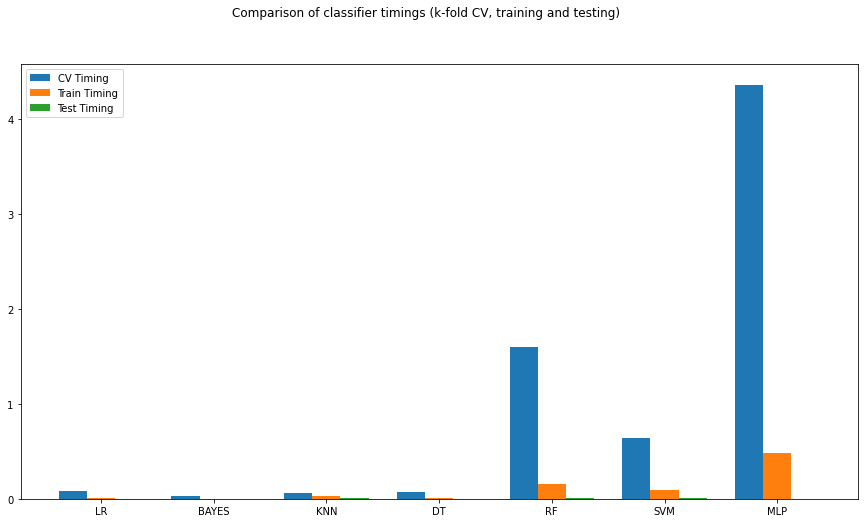

In [92]:
# Time spent in k-fold cross-validation, training and testing
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.25  # the width of the bars

fig.suptitle('Comparison of classifier timings (k-fold CV, training and testing)')
ax = fig.add_subplot(111)
plt.bar(ind - width, kfold_timing,  width=width, label='CV Timing')
plt.bar(ind, train_timing,  width=width, label='Train Timing')
plt.bar(ind + width, test_timing, width=width, label='Test Timing')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

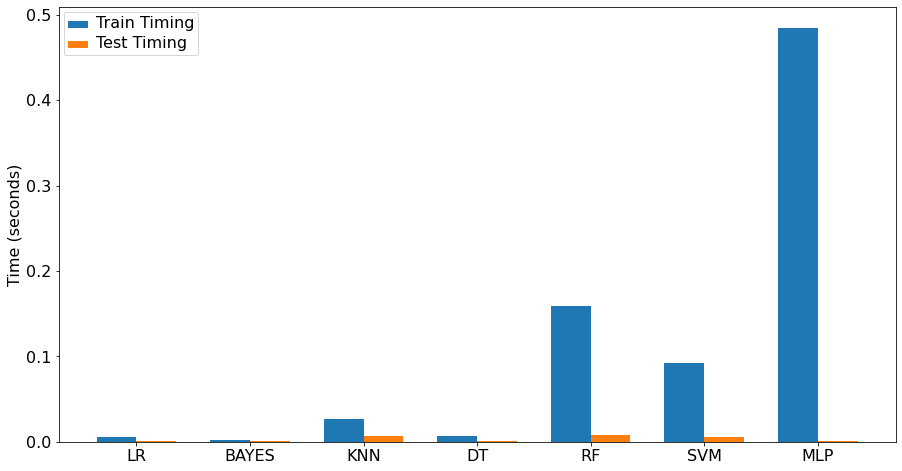

In [95]:
# Time spent in training and testing - Figure for the article
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

#fig.suptitle('Comparison of classifier timings (training and testing)')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_timing,  width=width, label='Train Timing')
plt.bar(ind + width/2, test_timing, width=width, label='Test Timing')
fig.set_size_inches(15,8)
plt.legend()
plt.ylabel('Time (seconds)')
ax.set_xticks(ind)
ax.set_xticklabels(names)
for item in ([ax.yaxis.label] + ax.legend().get_texts() + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'train_test_timings.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

#### Accuracy

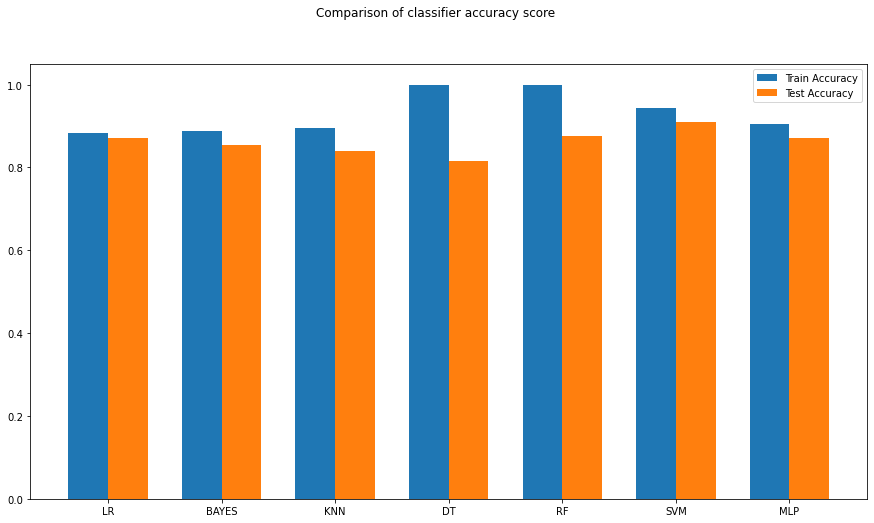

[0.8825, 0.8875, 0.89625, 1.0, 1.0, 0.94375, 0.90375]
[0.87, 0.855, 0.84, 0.815, 0.875, 0.91, 0.87]


In [96]:
# Train and test accuracy
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparison of classifier accuracy score')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_accuracy,  width=width, label='Train Accuracy')
plt.bar(ind + width/2, test_accuracy, width=width, label='Test Accuracy')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

print(train_accuracy)
print(test_accuracy)


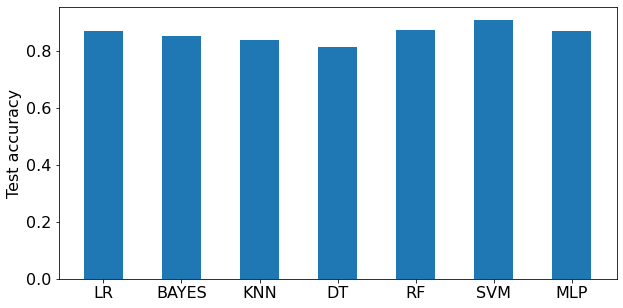

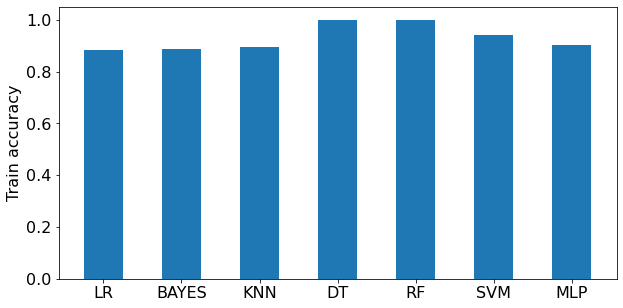

In [97]:
# Test accuracy - Figure for the article
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.50  # the width of the bars

ax = fig.add_subplot(111)
plt.bar(ind, test_accuracy,  width=width)
fig.set_size_inches(10,5)
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Test accuracy')
for item in ([ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'test_accuracy.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

# Train accuracy - Figure for the article
fig = plt.figure()

ax = fig.add_subplot(111)
plt.bar(ind, train_accuracy,  width=width)
fig.set_size_inches(10,5)
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Train accuracy')
for item in ([ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'train_accuracy.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

#### F1 score

In [98]:
# Calculate F1-score

names = []
train_F1 = []
test_F1 = []

#for name, model in models_tuned:
for name, model in models_default_params:
    names.append(name)
    
    # F1-score for the training data
    res = model.fit(X_train, y_train)
    train_result = f1_score(res.predict(X_train), y_train)
    train_F1.append(train_result)
    
    # F1-score for the test data
    y_pred = res.predict(X_test)
    test_result = f1_score(y_pred, y_test)
    test_F1.append(test_result)
    
    msg = "%s: %f %f" % (name, train_result, test_result)
    print(msg)

    print(confusion_matrix(y_pred, y_test))
    #print(classification_report(y_pred, y_test))

print("train F1-score:", train_F1)
print("test accuracy:", test_F1)


LR: 0.918118 0.912162
[[ 39   6]
 [ 20 135]]
BAYES: 0.920914 0.901695
[[ 38   8]
 [ 21 133]]
KNN: 0.928263 0.891892
[[ 36   9]
 [ 23 132]]
DT: 1.000000 0.872852
[[ 36  14]
 [ 23 127]]
RF: 1.000000 0.916388
[[ 38   4]
 [ 21 137]]
SVM: 0.960492 0.937931
[[ 46   5]
 [ 13 136]]
MLP: 0.931798 0.911565
[[ 40   7]
 [ 19 134]]
train F1-score: [0.9181184668989548, 0.9209138840070299, 0.9282627484874676, 1.0, 1.0, 0.9604916593503073, 0.9317980513728964]
test accuracy: [0.9121621621621622, 0.9016949152542373, 0.8918918918918919, 0.8728522336769758, 0.9163879598662208, 0.9379310344827586, 0.9115646258503401]


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


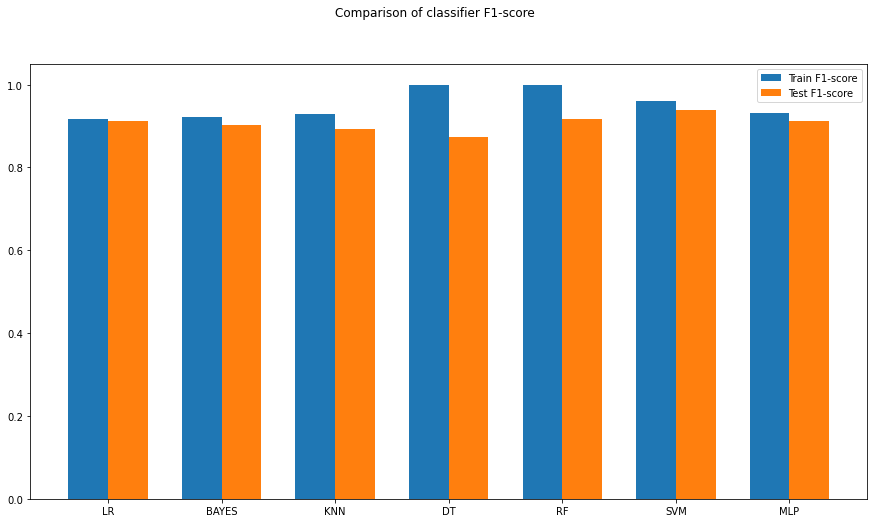

[0.9181184668989548, 0.9209138840070299, 0.9282627484874676, 1.0, 1.0, 0.9604916593503073, 0.9317980513728964]
[0.9121621621621622, 0.9016949152542373, 0.8918918918918919, 0.8728522336769758, 0.9163879598662208, 0.9379310344827586, 0.9115646258503401]


In [99]:
# Plot F1-score for train and test datasets
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparison of classifier F1-score')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_F1,  width=width, label='Train F1-score')
plt.bar(ind + width/2, test_F1, width=width, label='Test F1-score')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

print(train_F1)
print(test_F1)

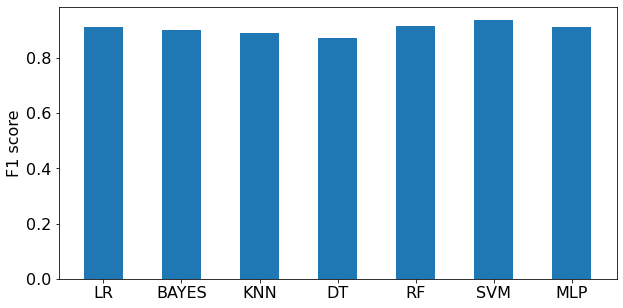

In [100]:
# Test F1 score - Figure for the article
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.50  # the width of the bars

ax = fig.add_subplot(111)
plt.bar(ind, test_F1,  width=width)
fig.set_size_inches(10,5)
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('F1 score')
for item in ([ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'test_F1.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


#### ROC Curves and AUC

In [104]:
# Calculate ROC curves
# Code is based on https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

names = []
test_fpr = []
test_tpr = []
test_auc = []

# generate a no-skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)    # Calculate score for the no-skill method
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)    # Calculate ROC curve for the no-skill method

#for name, model in models_tuned:
for name, model in models_default_params:
    names.append(name)    
    res = model.fit(X_train, y_train)

    res_probs = res.predict_proba(X_test)    # predict probabilities
    res_probs = res_probs[:, 1]   # keep probabilities for the positive outcome only
    
    # calculate scores
    res_auc = roc_auc_score(y_test, res_probs)
    test_auc.append(res_auc)
    
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('%s: ROC AUC=%.3f' % (name, res_auc))

    # calculate roc curves
    res_fpr, res_tpr, _ = roc_curve(y_test, res_probs)
    
    # add to list for plotting
    test_fpr.append(res_fpr)
    test_tpr.append(res_tpr)

print("ROC_fpr:", res_fpr)
print("ROC_tpr:", res_tpr)

No Skill: ROC AUC=0.500
LR: ROC AUC=0.859
No Skill: ROC AUC=0.500
BAYES: ROC AUC=0.850
No Skill: ROC AUC=0.500
KNN: ROC AUC=0.896
No Skill: ROC AUC=0.500
DT: ROC AUC=0.755
No Skill: ROC AUC=0.500
RF: ROC AUC=0.936
No Skill: ROC AUC=0.500
SVM: ROC AUC=0.951
No Skill: ROC AUC=0.500
MLP: ROC AUC=0.926
ROC_fpr: [0.         0.         0.         0.01694915 0.01694915 0.03389831
 0.03389831 0.05084746 0.05084746 0.06779661 0.06779661 0.08474576
 0.08474576 0.10169492 0.10169492 0.11864407 0.11864407 0.13559322
 0.13559322 0.15254237 0.15254237 0.18644068 0.18644068 0.20338983
 0.20338983 0.23728814 0.23728814 0.25423729 0.25423729 0.27118644
 0.27118644 0.3220339  0.3220339  0.33898305 0.33898305 0.38983051
 0.38983051 0.40677966 0.40677966 0.45762712 0.45762712 1.        ]
ROC_tpr: [0.         0.0070922  0.29787234 0.29787234 0.38297872 0.38297872
 0.5106383  0.5106383  0.58865248 0.58865248 0.69503546 0.69503546
 0.70212766 0.70212766 0.73758865 0.73758865 0.80141844 0.80141844
 0.87234043

c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


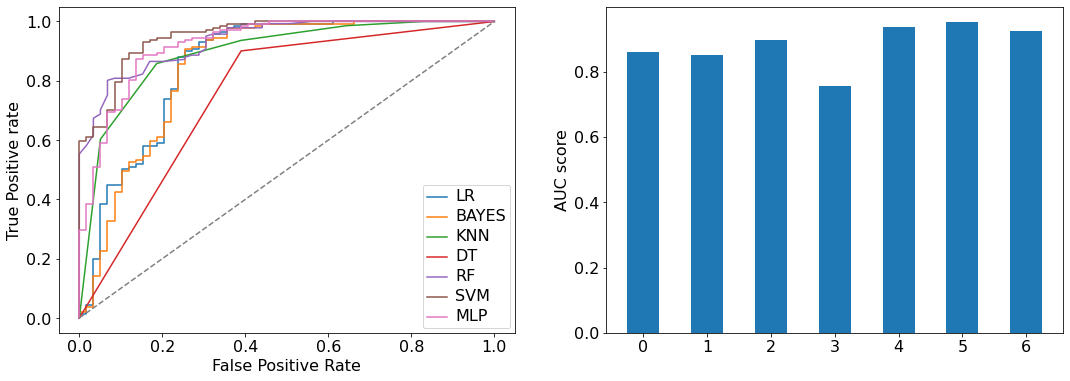

In [106]:
# Plot ROC curves and AUC scores for test data - Figure for the article
fig = plt.figure(figsize=(18,6))

ind = np.arange(len(names))  # the x locations for the groups
width = 0.5  # the width of the bars

# Plot ROC curves
ax = fig.add_subplot(121)
i = 0
#for name, model in models_tuned:
for name, model in models_default_params:
    plt.plot(test_fpr[i], test_tpr[i], label = name) 
    i = i+1

plt.plot(ns_fpr, ns_tpr, linestyle='--', color='gray')  # Random guessing curve (diagonal)
#plt.title('ROC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article


# Plot AUC scores in a bar plot
ax = fig.add_subplot(122)
plt.bar(ind, test_auc,  width=width, label='Test AUC')
#plt.title('AUC scores')
plt.ylabel('AUC score')
ax.set_xticks(ind)

for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'ROC_AUC.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

#### Summary of performance indicators (for a single seed)

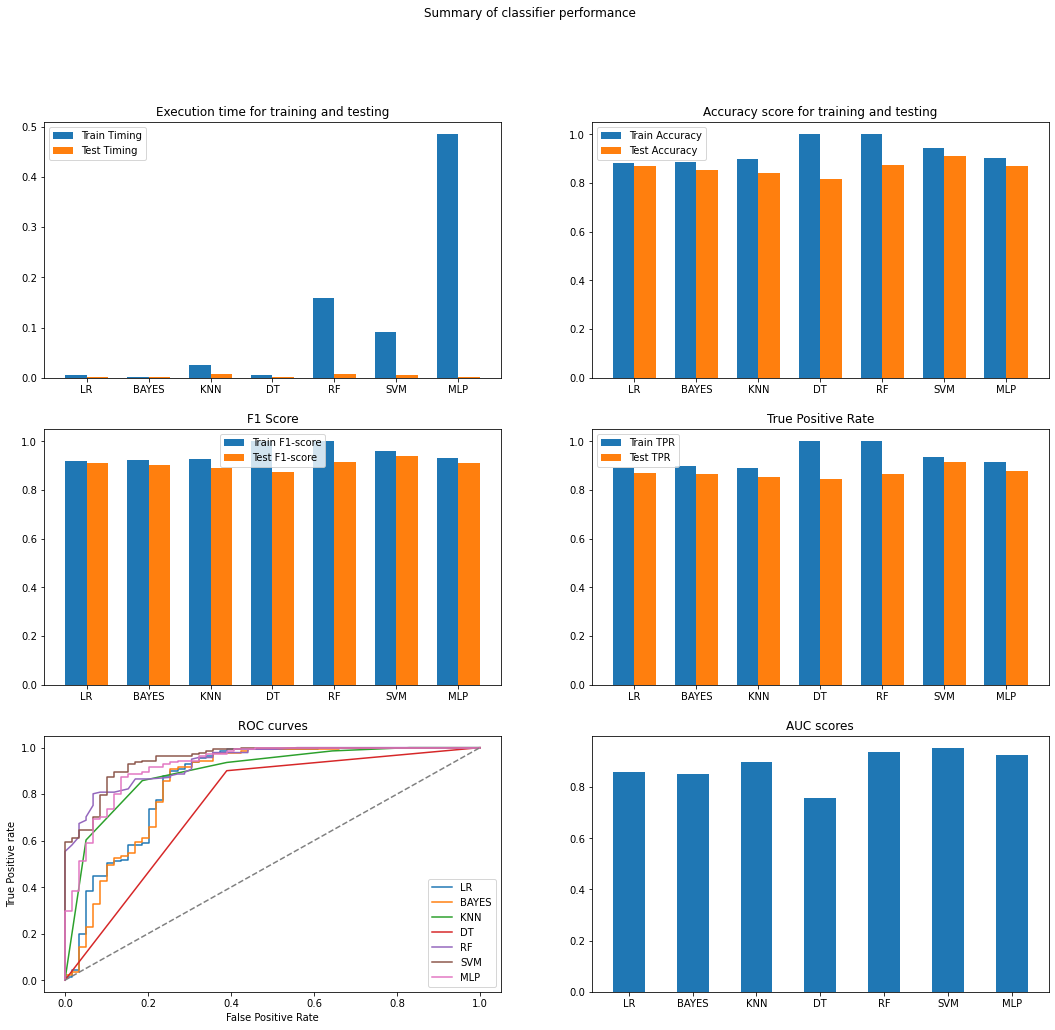

In [107]:

fig = plt.figure(figsize=(18,16))
fig.suptitle('Summary of classifier performance')
ind = np.arange(len(names))  # the x locations for the groups

# Time spent in training and testing
width = 0.35  # the width of the bars
ax = fig.add_subplot(321)
plt.bar(ind - width/2, train_timing,  width=width, label='Train Timing')
plt.bar(ind + width/2, test_timing, width=width, label='Test Timing')
plt.legend(loc='best')
plt.title('Execution time for training and testing')
ax.set_xticks(ind)
ax.set_xticklabels(names)

# Train and test accuracy
width = 0.35  # the width of the bars
ax = fig.add_subplot(322)
plt.bar(ind - width/2, train_accuracy,  width=width, label='Train Accuracy')
plt.bar(ind + width/2, test_accuracy, width=width, label='Test Accuracy')
plt.legend(loc='best')
plt.title('Accuracy score for training and testing')
ax.set_xticks(ind)
ax.set_xticklabels(names)

# F1-score
width = 0.35  # the width of the bars
ax = fig.add_subplot(323)
plt.bar(ind - width/2, train_F1,  width=width, label='Train F1-score')
plt.bar(ind + width/2, test_F1, width=width, label='Test F1-score')
plt.legend(loc='best')
plt.title('F1 Score')
ax.set_xticks(ind)
ax.set_xticklabels(names)

# True Positive Rate (TPR)
width = 0.35  # the width of the bars
ax = fig.add_subplot(324)
plt.bar(ind - width/2, train_TPR,  width=width, label='Train TPR')
plt.bar(ind + width/2, test_TPR, width=width, label='Test TPR')
plt.legend(loc='best')
plt.title('True Positive Rate')
ax.set_xticks(ind)
ax.set_xticklabels(names)

# ROC curves
ax = fig.add_subplot(325)
i = 0
#for name, model in models_tuned:
for name, model in models_default_params:
    plt.plot(test_fpr[i], test_tpr[i], label = name) 
    i = i+1

plt.plot(ns_fpr, ns_tpr, linestyle='--', color='gray')  # Random guessing curve (diagonal)
plt.title('ROC curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

# Bar plot of AUC scores
width = 0.5  # the width of the bars
ax = fig.add_subplot(326)
plt.bar(ind, test_auc,  width=width, label='Test AUC')
plt.title('AUC scores')
ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.show()

#########################################################################################################

### Overview of results for different java seeds

In [108]:
# Overview of results over different executions of the Java program (with different StartSeeds)

# Path to the folder of CSV files
java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\nSamples_' + str(nSamples) + '\\'
path, dirs, files = next(os.walk(java_folder))
file_count_seeds = len(files)

# Create a list of dataframes, one for each csv file
ABM_prices_df_list = []
ABM_returns_df_list = []

for i in range(file_count_seeds):
    temp_prices_df = pd.read_csv(java_folder + files[i])
    temp_prices_df = temp_prices_df.drop(['tick'], axis=1)   # Delete column of ticks
    ABM_prices_df_list.append(temp_prices_df)

    temp_returns_df = temp_prices_df.pct_change()
    temp_returns_df = temp_returns_df.drop(temp_returns_df.index[0])  # Delete first row (= NaN)
    ABM_returns_df_list.append(temp_returns_df.transpose())


# Extract number of runs and ticks 
nTicks = ABM_prices_df_list[0].shape[0]
nRuns = ABM_prices_df_list[0].shape[1]
print("nTicks:", nTicks)
print("nRuns:", nRuns)

nTicks: 4000
nRuns: 1000


In [109]:
# Analyse the stylised facts for each dataframe
y_list_seeds =  []   # List to store whether stylised facts are satisfied or not (-> y vectors)

for i in range(file_count_seeds):
    # Excess kurtosis of returns
    temp_kurtosis_ret = kurtosis(ABM_returns_df_list[i], axis=1, fisher=True, bias=False)

    # Hurst exponent of returns
    Hurst_vector_ret = np.zeros(nRuns)  # Vector to store the Hurst exponent of the different return time series
    for j in range(0, nRuns):
        H = get_hurst_exponent(ABM_prices_df_list[i].iloc[:,j].values, Hurst_max_lag)
        Hurst_vector_ret[j] = H
    temp_Hurst_ret = Hurst_vector_ret

    # Engle's ARCH test for volatility
    pval_Lagrange = np.zeros(nRuns)
    for j in range(0, nRuns):
        etest = het_arch(ABM_returns_df_list[i].iloc[j], nlags=5)
        pval_Lagrange[j] = np.round(etest[1], 4)  # Lagrange multiplier test
    temp_ARCH_vol = pval_Lagrange

    # Skewness of volatility (=returns^2)
    temp_skewness_vol = skew(pow(ABM_returns_df_list[i],2), axis=1, bias=False)

    # Check if stylised facts are satisfied
    SF_satisfied = np.zeros(nRuns, dtype=int)
    for j in range(0, nRuns):
    	if (temp_kurtosis_ret[j]>0 and temp_Hurst_ret[j]>0.45 and temp_Hurst_ret[j]<0.55 and temp_ARCH_vol[j]<0.01 and temp_skewness_vol[j]>0):
            SF_satisfied[j] = 1
    
    y_list_seeds.append(SF_satisfied)

#print(y_list_seeds[0:50])

In [110]:
# For each dataframe, train the ML classifiers and calculate the performance measures
seeds = []
train_accuracy_list = []
train_timing_list = []
test_accuracy_list = []
test_timing_list = []
train_f1_list = []
test_f1_list = []
test_auc_list = []

for i in range(file_count_seeds):
    col_name = "seed" + str(i+1)
    seeds.append(col_name)

    # Split X,y into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(parameters_df, y_list_seeds[i], test_size = test_size, random_state = 5)  # Set random state for reproducibility
    
    # Train and test the ML classifiers
    names = []
    train_accuracy = []
    train_timing = []
    test_accuracy = []
    test_timing = []
    train_f1 = []
    test_f1 = []
    test_auc = []

    #for name, model in models_tuned:
    for name, model in models_default_params:
        names.append(name)
        # Accuracy for the training data
        start_time = time.perf_counter()
        res = model.fit(X_train, y_train)
        train_result = accuracy_score(res.predict(X_train), y_train)
        train_accuracy.append(train_result)
        end_time = time.perf_counter()
        train_timing.append(end_time-start_time) 
    
        # Accuracy for the test data
        start_time = time.perf_counter()
        y_pred = res.predict(X_test)
        test_result = accuracy_score(y_pred, y_test)
        test_accuracy.append(test_result)
        end_time = time.perf_counter()
        test_timing.append(end_time-start_time)

        # F1-score
        train_result = f1_score(res.predict(X_train), y_train)
        train_f1.append(train_result)
        test_result = f1_score(y_pred, y_test)
        test_f1.append(test_result)

        # AUC score
        res_probs = res.predict_proba(X_test)    # predict probabilities
        res_probs = res_probs[:, 1]   # keep probabilities for the positive outcome only
        test_result = roc_auc_score(y_test, res_probs)
        test_auc.append(test_result)
     
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    train_timing_list.append(train_timing)
    test_timing_list.append(test_timing)
    train_f1_list.append(train_f1)
    test_f1_list.append(test_f1)
    test_auc_list.append(test_auc)

    
# Convert lists of performance measures to dataframes
train_accuracy_df = pd.DataFrame(train_accuracy_list)
test_accuracy_df = pd.DataFrame(test_accuracy_list)
train_timing_df = pd.DataFrame(train_timing_list)
test_timing_df = pd.DataFrame(test_timing_list)
train_f1_df = pd.DataFrame(train_f1_list)
test_f1_df = pd.DataFrame(test_f1_list)
test_auc_df = pd.DataFrame(test_auc_list)

print(train_accuracy_df.shape)

train_accuracy_df.columns = names        
test_accuracy_df.columns = names
train_timing_df.columns = names
test_timing_df.columns = names
train_f1_df.columns = names
test_f1_df.columns = names
test_auc_df.columns = names

display(train_accuracy_df)
display(test_accuracy_df)
display(train_timing_df)
display(test_timing_df)


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.88250,0.88750,0.89625,1.0,1.0,0.94375,0.90375
1,0.87250,0.87625,0.89000,1.0,1.0,0.93750,0.91250
2,0.82875,0.83625,0.89875,1.0,1.0,0.89875,0.88000
3,0.82625,0.81875,0.86375,1.0,1.0,0.90375,0.88000
4,0.89000,0.87875,0.86500,1.0,1.0,0.94000,0.90875
5,0.86375,0.87250,0.89500,1.0,1.0,0.93125,0.91000
6,0.88875,0.88375,0.87625,1.0,1.0,0.93125,0.90875
7,0.88750,0.87375,0.90625,1.0,1.0,0.94625,0.91125
8,0.87250,0.86000,0.88625,1.0,1.0,0.93375,0.90375
9,0.84000,0.84750,0.86500,1.0,1.0,0.91000,0.90000


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.870,0.855,0.840,0.815,0.875,0.910,0.870
1,0.865,0.880,0.810,0.825,0.855,0.860,0.875
2,0.810,0.805,0.865,0.825,0.845,0.835,0.875
3,0.770,0.755,0.770,0.685,0.790,0.810,0.835
4,0.840,0.810,0.820,0.735,0.815,0.855,0.850
5,0.840,0.840,0.825,0.795,0.820,0.860,0.870
6,0.845,0.835,0.795,0.770,0.830,0.845,0.870
7,0.835,0.780,0.800,0.780,0.770,0.845,0.835
8,0.820,0.790,0.780,0.750,0.805,0.840,0.840
9,0.820,0.825,0.795,0.735,0.830,0.810,0.830


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.007492,0.003868,0.065976,0.013149,0.397046,0.166579,0.736055
1,0.010305,0.004676,0.057636,0.013824,0.305198,0.147313,0.867566
2,0.012446,0.005107,0.065003,0.012454,0.406554,0.146600,0.724205
3,0.010822,0.005243,0.050094,0.017016,0.379600,0.229360,0.893463
4,0.011040,0.005063,0.062096,0.014273,0.388904,0.154198,0.610869
5,0.009675,0.003486,0.055316,0.017539,0.374505,0.167734,0.771563
6,0.011296,0.003682,0.055952,0.013596,0.395941,0.177059,0.582209
7,0.005754,0.003283,0.051617,0.010907,0.326055,0.191950,0.676423
8,0.007881,0.003720,0.057042,0.011316,0.370671,0.184921,0.602736
9,0.008973,0.004206,0.049325,0.012513,0.357016,0.191333,0.733891


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.001572,0.001916,0.017010,0.001809,0.017929,0.012461,0.002313
1,0.001626,0.002128,0.013187,0.001303,0.012394,0.011294,0.001916
2,0.001209,0.002002,0.015760,0.001744,0.014965,0.013784,0.002380
3,0.001614,0.001980,0.016755,0.001660,0.016256,0.012805,0.002464
4,0.000959,0.001366,0.015162,0.001136,0.017144,0.009554,0.001386
5,0.001017,0.001593,0.019222,0.001693,0.011029,0.009496,0.001946
6,0.001613,0.001217,0.015574,0.001033,0.013476,0.016044,0.002214
7,0.000896,0.001595,0.015223,0.001348,0.016177,0.005912,0.001505
8,0.001328,0.001557,0.015978,0.001253,0.015216,0.020437,0.001940
9,0.001405,0.001592,0.014279,0.001097,0.008961,0.008957,0.002043


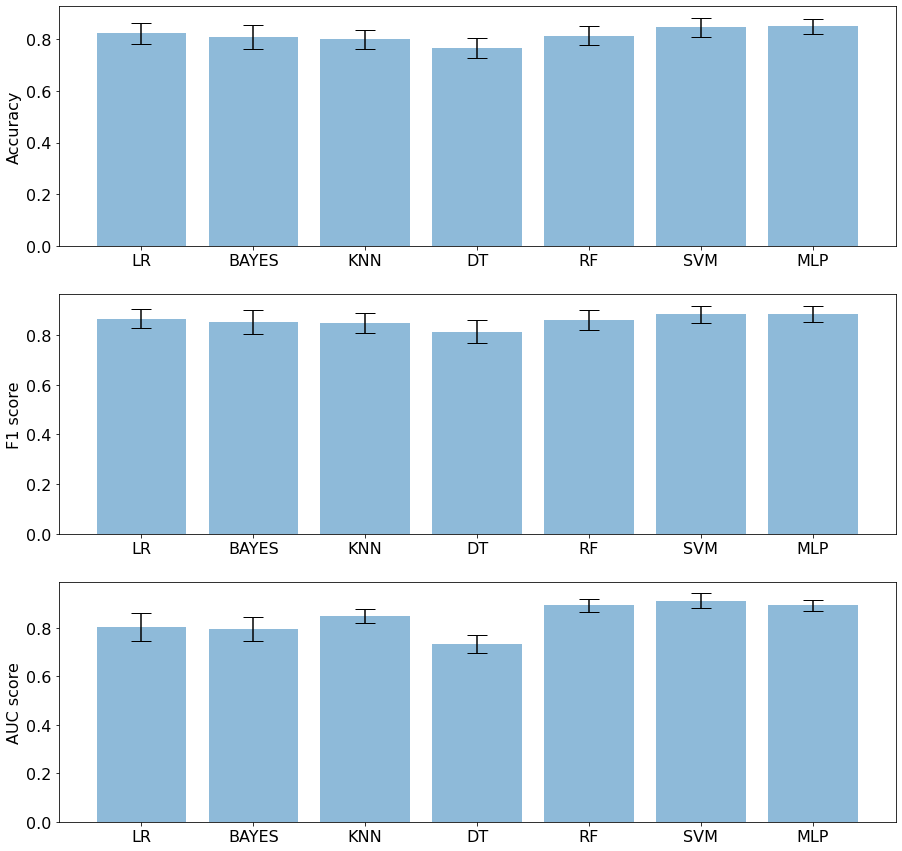

In [112]:
# Error diagram - Figure for the article

fig = plt.figure(figsize=(15,15))

ind = np.arange(len(names))  # the x locations for the groups
width = 0.5  # the width of the bars

ax = fig.add_subplot(311)
plt.bar(ind, test_accuracy_df.mean(), yerr=test_accuracy_df.std(), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(names)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(312)
plt.bar(ind, test_f1_df.mean(), yerr=test_f1_df.std(), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('F1 score')
ax.set_xticks(ind)
ax.set_xticklabels(names)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(313)
plt.bar(ind, test_auc_df.mean(), yerr=test_auc_df.std(), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('AUC score')
ax.set_xticks(ind)
ax.set_xticklabels(names)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article


plt.savefig(figures_folder + 'error_bars.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


#### Summary of performance indicators along seeds

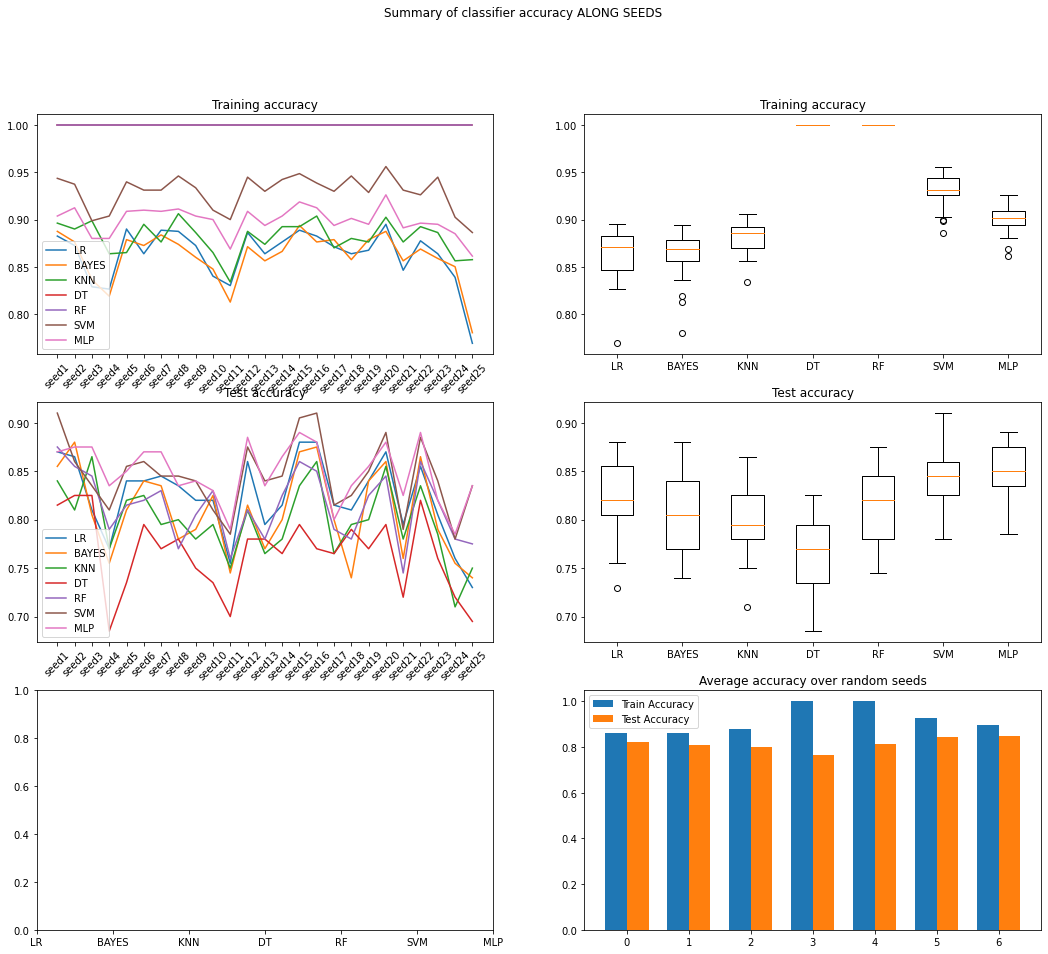

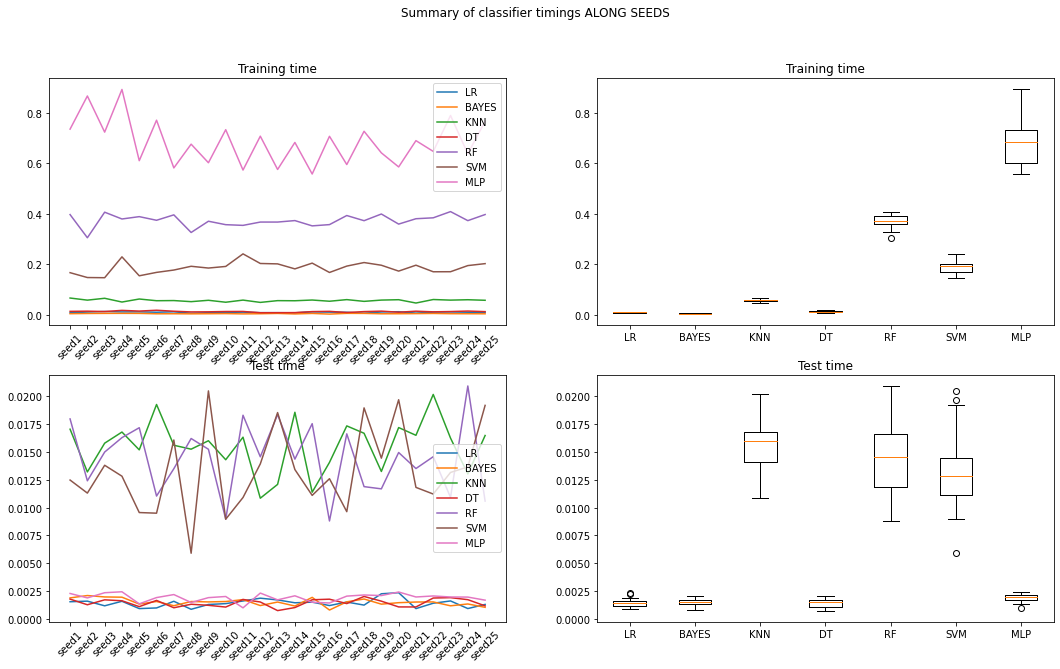

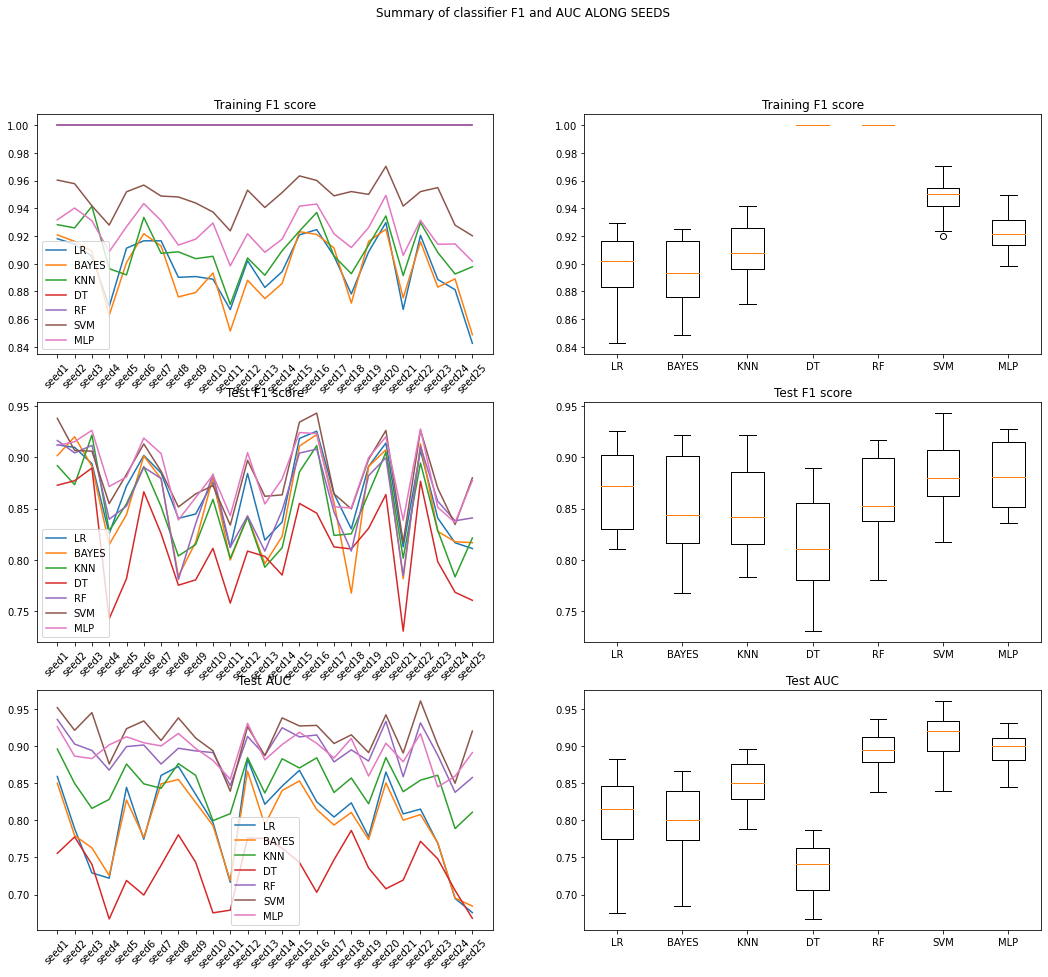

Mean of accuracy: LR       0.8232
BAYES    0.8080
KNN      0.7990
DT       0.7656
RF       0.8136
SVM      0.8456
MLP      0.8488
dtype: float64
St. dev. of accuracy: LR       0.040308
BAYES    0.045162
KNN      0.037666
DT       0.040008
RF       0.035075
SVM      0.036524
MLP      0.030526
dtype: float64
Mean of F1 score: LR       0.865854
BAYES    0.852406
KNN      0.847440
DT       0.813363
RF       0.859531
SVM      0.883113
MLP      0.883717
dtype: float64
St. dev. of F1 score: LR       0.039034
BAYES    0.049271
KNN      0.040594
DT       0.045776
RF       0.041072
SVM      0.034854
MLP      0.032249
dtype: float64
Mean of AUC: LR       0.802930
BAYES    0.796523
KNN      0.848497
DT       0.733034
RF       0.892492
SVM      0.912621
MLP      0.893775
dtype: float64
St. dev. of AUC: LR       0.058338
BAYES    0.050452
KNN      0.029665
DT       0.037037
RF       0.026142
SVM      0.029725
MLP      0.022556
dtype: float64


In [113]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,15))
fig.suptitle('Summary of classifier accuracy ALONG SEEDS')
ind = np.arange(len(names))  # the x locations for the groups

# ---- Training accuracy ---- #
# Line plot
ax=axes[0,0]
train_accuracy_df.plot(ax=ax, title='Training accuracy')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[0,1]
ax.boxplot(train_accuracy_df)
ax.set_title('Training accuracy')
ax.set_xticklabels(names)

# ---- Testing accuracy ---- #
# Line plot
ax=axes[1,0]
test_accuracy_df.plot(ax=ax, title='Test accuracy')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[1,1]
ax.boxplot(test_accuracy_df)
ax.set_title('Test accuracy')
ax.set_xticklabels(names)


# ---- Train vs test accuracy ---- #
ax = axes[2,0]
width = 0.35  # the width of the bars
plt.bar(ind - width/2, train_accuracy_df.mean(),  width=width, label='Train Accuracy')
plt.bar(ind + width/2, test_accuracy_df.mean(), width=width, label='Test Accuracy')
plt.legend(loc='best')
plt.title('Average accuracy over random seeds')
ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.show()



fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
fig.suptitle('Summary of classifier timings ALONG SEEDS')

# ---- Training timing ---- #
# Line plot
ax=axes[0,0]
train_timing_df.plot(ax=ax, title='Training time')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[0,1]
ax.boxplot(train_timing_df)
ax.set_title('Training time')
ax.set_xticklabels(names)

# ---- Test timing ---- #
# Line plot
ax=axes[1,0]
test_timing_df.plot(ax=ax, title='Test time')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[1,1]
ax.boxplot(test_timing_df)
ax.set_title('Test time')
ax.set_xticklabels(names)

plt.show()


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,15))
fig.suptitle('Summary of classifier F1 and AUC ALONG SEEDS')

# ---- Train F1 ---- #
# Line plot
ax=axes[0,0]
train_f1_df.plot(ax=ax, title='Training F1 score')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[0,1]
ax.boxplot(train_f1_df)
ax.set_title('Training F1 score')
ax.set_xticklabels(names)

# ---- Test F1 ---- #
# Line plot
ax=axes[1,0]
test_f1_df.plot(ax=ax, title='Test F1 score')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[1,1]
ax.boxplot(test_f1_df)
ax.set_title('Test F1 score')
ax.set_xticklabels(names)

# ---- Test AUC ---- #
# Line plot
ax=axes[2,0]
test_auc_df.plot(ax=ax, title='Test AUC')
x_ticks = range(file_count_seeds)
x_labels = seeds
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=45)

# Boxplot
ax = axes[2,1]
ax.boxplot(test_auc_df)
ax.set_title('Test AUC')
ax.set_xticklabels(names)

plt.show()

print("Mean of accuracy:", test_accuracy_df.mean())
print("St. dev. of accuracy:", test_accuracy_df.std())
print("Mean of F1 score:", test_f1_df.mean())
print("St. dev. of F1 score:", test_f1_df.std())
print("Mean of AUC:", test_auc_df.mean())
print("St. dev. of AUC:", test_auc_df.std())



##################################################################################################

### Overview of results for different sample sizes

In [114]:
# Overview of results for different sample sizes (with the same StartSeed)

# Path to the folder of CSV files
java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\seed_' + str(java_seed) + '\\'
path, dirs, files = next(os.walk(java_folder))
file_count_samples = len(files)

# Create a list of dataframes, one for each csv file
ABM_prices_df_list = []
ABM_returns_df_list = []

for i in range(file_count_samples):
    temp_prices_df = pd.read_csv(java_folder + files[i])
    temp_prices_df = temp_prices_df.drop(['tick'], axis=1)   # Delete column of ticks
    ABM_prices_df_list.append(temp_prices_df)

    temp_returns_df = temp_prices_df.pct_change()
    temp_returns_df = temp_returns_df.drop(temp_returns_df.index[0])  # Delete first row (= NaN)
    ABM_returns_df_list.append(temp_returns_df.transpose())


['java_price_timeseries_11_00200_seed965.csv', 'java_price_timeseries_11_00500_seed965.csv', 'java_price_timeseries_11_01000_seed965.csv', 'java_price_timeseries_11_02000_seed965.csv', 'java_price_timeseries_11_05000_seed965.csv', 'java_price_timeseries_11_10000_seed965.csv']


In [115]:
# Analyse the stylised facts for each dataframe
y_list_samples = []   # List to store whether stylised facts are satisfied or not (-> y vectors)

for i in range(file_count_samples):
    # Extract number of runs and ticks 
    nTicks = ABM_prices_df_list[i].shape[0]
    nRuns = ABM_prices_df_list[i].shape[1]
    
    # Excess kurtosis of returns
    temp_kurtosis_ret = kurtosis(ABM_returns_df_list[i], axis=1, fisher=True, bias=False)

    # Hurst exponent of returns
    Hurst_vector_ret = np.zeros(nRuns)  # Vector to store the Hurst exponent of the different return time series
    for j in range(0, nRuns):
        H = get_hurst_exponent(ABM_prices_df_list[i].iloc[:,j].values, Hurst_max_lag)
        Hurst_vector_ret[j] = H
    temp_Hurst_ret = Hurst_vector_ret

    # Engle's ARCH test for volatility
    pval_Lagrange = np.zeros(nRuns)
    for j in range(0, nRuns):
        etest = het_arch(ABM_returns_df_list[i].iloc[j], nlags=5)
        pval_Lagrange[j] = np.round(etest[1], 4)  # Lagrange multiplier test
    temp_ARCH_vol = pval_Lagrange

    # Skewness of volatility (=returns^2)
    temp_skewness_vol = skew(pow(ABM_returns_df_list[i],2), axis=1, bias=False)

    # Check if stylised facts are satisfied
    SF_satisfied = np.zeros(nRuns, dtype=int)
    for j in range(0, nRuns):
    	if (temp_kurtosis_ret[j]>0 and temp_Hurst_ret[j]>0.45 and temp_Hurst_ret[j]<0.55 and temp_ARCH_vol[j]<0.01 and temp_skewness_vol[j]>0):
            SF_satisfied[j] = 1
    
    y_list_samples.append(SF_satisfied)


nTicks: 4000
nRuns: 200
nTicks: 4000
nRuns: 500
nTicks: 4000
nRuns: 1000
nTicks: 4000
nRuns: 2000
nTicks: 4000
nRuns: 5000
nTicks: 4000
nRuns: 10000


In [116]:
# For each dataframe, train the ML classifiers and calculate the performance measures
labels_nSamples = []
train_accuracy_list = []
test_accuracy_list = []
train_timing_list = []
test_timing_list = []
train_f1_list = []
test_f1_list = []
test_auc_list = []

for i in range(file_count_samples):
    col_name = "nSample_" + str(ABM_prices_df_list[i].shape[1])   # nRuns
    labels_nSamples.append(col_name)

    # Recover sampling of parameters (X dataset)
    print(nParamsLHS)
    np.random.seed(LHS_seed)
    temp_parameters = lhs(nParamsLHS, samples=ABM_prices_df_list[i].shape[1], criterion='center')
    temp_parameters_df = pd.DataFrame(temp_parameters)
    temp_parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset']

    # Split X,y into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(temp_parameters_df, y_list_samples[i], test_size = test_size, random_state = 5)  # Set random state for reproducibility
    
    # Train and test the ML classifiers
    names = []
    train_accuracy = []
    test_accuracy = []
    train_timing = []
    test_timing = []
    train_f1 = []
    test_f1 = []
    test_auc = []

    #for name, model in models_tuned:
    for name, model in models_default_params:
        names.append(name)
        # Accuracy for the training data
        start_time = time.perf_counter()
        res = model.fit(X_train, y_train)
        train_result = accuracy_score(res.predict(X_train), y_train)
        train_accuracy.append(train_result)
        end_time = time.perf_counter()
        train_timing.append(end_time-start_time) 
    
        # Accuracy for the test data
        start_time = time.perf_counter()
        y_pred = res.predict(X_test)
        test_result = accuracy_score(y_pred, y_test)
        test_accuracy.append(test_result)
        end_time = time.perf_counter()
        test_timing.append(end_time-start_time)

        # F1 score
        train_result = f1_score(res.predict(X_train), y_train)
        train_f1.append(train_result)
        test_result = f1_score(y_pred, y_test)
        test_f1.append(test_result)
        
        # AUC score
        res_probs = res.predict_proba(X_test)    # predict probabilities
        res_probs = res_probs[:, 1]   # keep probabilities for the positive outcome only
        test_result = roc_auc_score(y_test, res_probs)
        test_auc.append(test_result)
        
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    train_timing_list.append(train_timing)
    test_timing_list.append(test_timing)
    train_f1_list.append(train_f1)
    test_f1_list.append(test_f1)
    test_auc_list.append(test_auc)
    

# Convert lists of performance measures to dataframes
train_accuracy_df = pd.DataFrame(train_accuracy_list)
test_accuracy_df = pd.DataFrame(test_accuracy_list)
train_timing_df = pd.DataFrame(train_timing_list)
test_timing_df = pd.DataFrame(test_timing_list)
train_f1_df = pd.DataFrame(train_f1_list)
test_f1_df = pd.DataFrame(test_f1_list)
test_auc_df = pd.DataFrame(test_auc_list)

print(train_accuracy_df.shape)

train_accuracy_df.columns = names        
test_accuracy_df.columns = names
train_timing_df.columns = names
test_timing_df.columns = names
train_f1_df.columns = names
test_f1_df.columns = names
test_auc_df.columns = names

display(train_accuracy_df)
display(test_accuracy_df)
display(train_timing_df)
display(test_timing_df)

['nSample_200']
11
       0       1       2       3       4       5       6       7       8   \
0  0.8225  0.3475  0.2125  0.3625  0.9725  0.4625  0.9525  0.9125  0.7325   
1  0.8075  0.3525  0.6975  0.0075  0.9175  0.8275  0.2175  0.5775  0.4425   
2  0.2175  0.6375  0.8825  0.8825  0.2975  0.6625  0.3275  0.9275  0.0475   
3  0.4025  0.5475  0.0775  0.0275  0.6675  0.9925  0.4575  0.6075  0.0225   
4  0.7275  0.8275  0.2275  0.4975  0.7325  0.2575  0.0325  0.8675  0.8225   

       9       10  
0  0.1525  0.8475  
1  0.7825  0.5175  
2  0.8675  0.2875  
3  0.4575  0.1875  
4  0.2575  0.6225  


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500']
11
      0      1      2      3      4      5      6      7      8      9      10
0  0.245  0.383  0.891  0.007  0.885  0.659  0.075  0.581  0.067  0.781  0.739
1  0.467  0.687  0.075  0.985  0.011  0.789  0.727  0.021  0.275  0.981  0.227
2  0.183  0.987  0.553  0.601  0.177  0.755  0.341  0.063  0.539  0.279  0.497
3  0.133  0.979  0.083  0.525  0.945  0.645  0.875  0.777  0.779  0.103  0.519
4  0.987  0.507  0.415  0.637  0.587  0.529  0.807  0.835  0.889  0.789  0.103


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000']
11
       0       1       2       3       4       5       6       7       8   \
0  0.8195  0.9755  0.8185  0.0235  0.1995  0.2725  0.6065  0.9095  0.6065   
1  0.0175  0.1985  0.8225  0.8875  0.5255  0.7635  0.7035  0.3955  0.3825   
2  0.7025  0.8945  0.6355  0.2885  0.2825  0.1665  0.6765  0.1315  0.2985   
3  0.2275  0.4885  0.1345  0.8595  0.5565  0.9625  0.7925  0.0795  0.2815   
4  0.6445  0.2825  0.3485  0.7365  0.2925  0.6635  0.0985  0.1925  0.9805   

       9       10  
0  0.7005  0.6815  
1  0.5265  0.4545  
2  0.2535  0.7185  
3  0.5555  0.9485  
4  0.9085  0.2295  


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000']
11
        0        1        2        3        4        5        6        7   \
0  0.32275  0.67425  0.91025  0.07075  0.48475  0.31625  0.01875  0.14675   
1  0.41175  0.49575  0.35825  0.04775  0.29075  0.78875  0.88075  0.15125   
2  0.32825  0.63025  0.28525  0.47375  0.47675  0.37475  0.27125  0.21325   
3  0.94275  0.72475  0.36875  0.12375  0.88775  0.10975  0.94375  0.55925   
4  0.71875  0.96375  0.10575  0.01225  0.83175  0.56875  0.06625  0.28425   

        8        9        10  
0  0.78425  0.10175  0.53975  
1  0.58475  0.72175  0.03675  
2  0.46375  0.32825  0.78675  
3  0.89825  0.70225  0.57075  
4  0.91525  0.60675  0.23025  


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000', 'nSample_5000']
11
       0       1       2       3       4       5       6       7       8   \
0  0.4245  0.1793  0.5595  0.3237  0.6251  0.8181  0.0909  0.7759  0.6227   
1  0.6549  0.3211  0.7529  0.7325  0.3875  0.8583  0.1055  0.6177  0.0833   
2  0.4309  0.8829  0.1087  0.0141  0.0197  0.9705  0.1465  0.9859  0.6061   
3  0.9011  0.1155  0.7799  0.7847  0.2015  0.2783  0.3005  0.0887  0.4441   
4  0.1701  0.9897  0.1929  0.1855  0.8963  0.5265  0.6679  0.5521  0.3571   

       9       10  
0  0.2647  0.2667  
1  0.5681  0.0421  
2  0.9395  0.7149  
3  0.3049  0.8337  
4  0.3491  0.2861  


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000', 'nSample_5000', 'nSample_10000']
11
        0        1        2        3        4        5        6        7   \
0  0.72985  0.80755  0.91325  0.87155  0.65965  0.14895  0.96665  0.55215   
1  0.64455  0.78775  0.44655  0.42605  0.49055  0.46075  0.35315  0.51675   
2  0.71015  0.65065  0.78355  0.30935  0.76095  0.26315  0.47925  0.37605   
3  0.45345  0.93495  0.88975  0.65605  0.96665  0.84305  0.73385  0.68305   
4  0.93415  0.09925  0.91075  0.64035  0.43375  0.77965  0.74275  0.09545   

        8        9        10  
0  0.21055  0.74465  0.57555  
1  0.22285  0.46725  0.03345  
2  0.48635  0.43325  0.77945  
3  0.45615  0.19555  0.39225  
4  0.96685  0.36055  0.48715  
(6, 7)


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.862500,0.856250,0.89375,1.0,1.0,0.950000,0.881250
1,0.855000,0.855000,0.88000,1.0,1.0,0.942500,0.872500
2,0.882500,0.887500,0.89625,1.0,1.0,0.943750,0.903750
3,0.869375,0.870625,0.90750,1.0,1.0,0.943125,0.913750
4,0.887500,0.879250,0.90650,1.0,1.0,0.941750,0.933250
5,0.878000,0.876125,0.91700,1.0,1.0,0.945500,0.938875


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.8500,0.8500,0.7000,0.6750,0.8500,0.7500,0.8250
1,0.8400,0.8600,0.8500,0.8400,0.9300,0.8500,0.8500
2,0.8700,0.8550,0.8400,0.8150,0.8750,0.9100,0.8700
3,0.9075,0.9075,0.8350,0.8325,0.8925,0.9400,0.9250
4,0.8760,0.8690,0.8430,0.8510,0.8930,0.9210,0.9230
5,0.8785,0.8805,0.8615,0.8300,0.8980,0.9225,0.9295


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.009379,0.002632,0.008347,0.004754,0.181541,0.015507,0.149765
1,0.008844,0.002558,0.020382,0.007805,0.293789,0.063674,0.346835
2,0.013212,0.004779,0.048280,0.013088,0.409932,0.210032,0.820160
3,0.012373,0.032816,0.179382,0.025284,0.516535,0.559438,1.362912
4,0.012445,0.009421,0.691107,0.048152,0.961577,2.561568,3.349637
5,0.016382,0.009249,1.332071,0.104642,1.775772,7.551676,6.102553


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.001332,0.001258,0.003566,0.001064,0.010094,0.004260,0.001493
1,0.001661,0.001131,0.005416,0.001464,0.023431,0.004016,0.001507
2,0.001927,0.001355,0.014639,0.001043,0.012860,0.009753,0.002731
3,0.001017,0.001962,0.044687,0.002145,0.018623,0.049606,0.001575
4,0.001605,0.001196,0.160334,0.001751,0.023642,0.237036,0.001937
5,0.002094,0.001638,0.335966,0.002542,0.037277,0.435409,0.005494


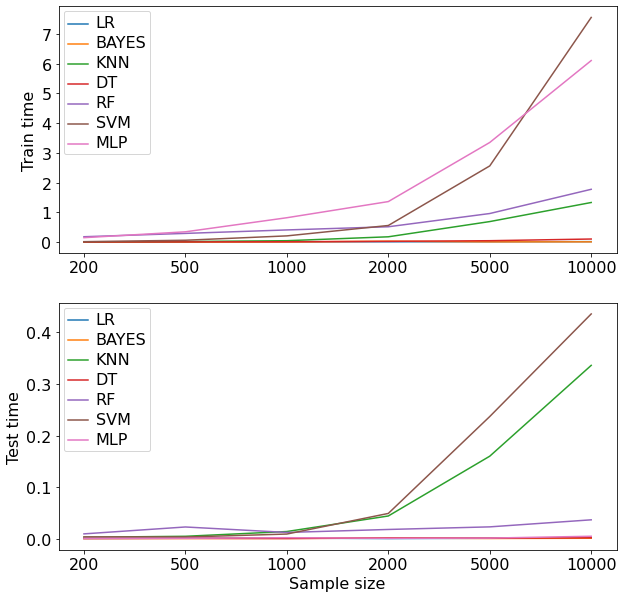

In [118]:
# Train and test timings along nSamples (results for one random seed) - Figure for the article

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211)
train_timing_df.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
#ax.set_xlabel('Sample size')
ax.set_ylabel('Train time')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(212)
test_timing_df.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_xlabel('Sample size')
ax.set_ylabel('Test time')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()+ ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article


plt.savefig(figures_folder + 'train_test_time_over_nsamples.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


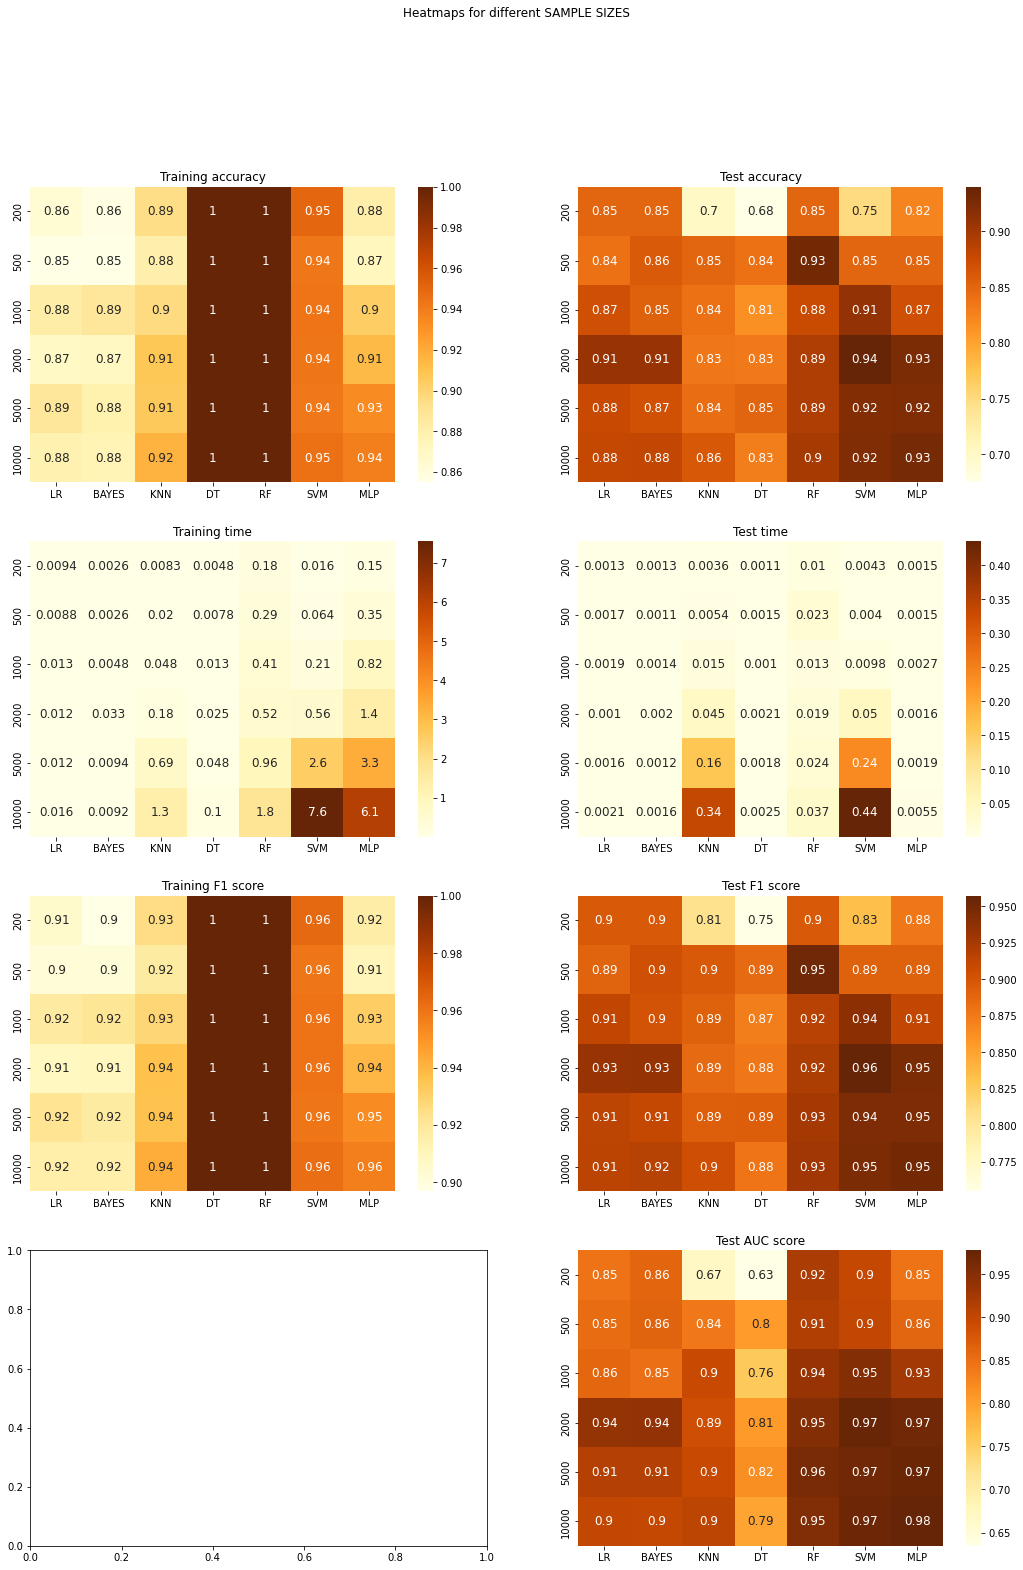

In [119]:
## ---- Heatmaps (for a single seed) ----- #
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,25))
fig.suptitle('Heatmaps for different SAMPLE SIZES')

# ---- Accuracy ---- #
ax=axes[0,0]
sns.heatmap(train_accuracy_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Training accuracy')

ax=axes[0,1]
sns.heatmap(test_accuracy_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Test accuracy')

ax=axes[1,0]
sns.heatmap(train_timing_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Training time')

ax=axes[1,1]
sns.heatmap(test_timing_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Test time')

ax=axes[2,0]
sns.heatmap(train_f1_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Training F1 score')

ax=axes[2,1]
sns.heatmap(test_f1_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Test F1 score')

ax=axes[3,1]
sns.heatmap(test_auc_df, ax=ax, annot=True, annot_kws={"size": 12}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
ax.set_title('Test AUC score')

plt.show()



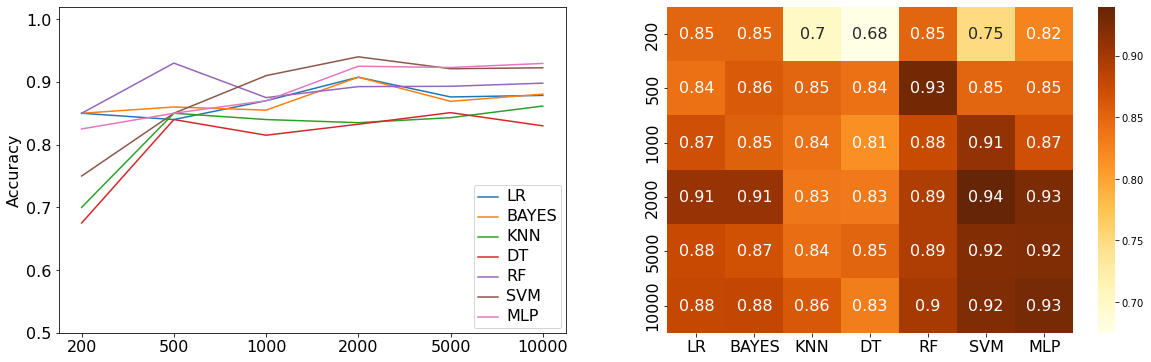

In [120]:
# Line plot + Heatmap of test ACCURACY - Figure for the article

fig = plt.figure(figsize=(20,6))

# Line plot
ax = fig.add_subplot(121)
test_accuracy_df.plot(ax=ax)
x_ticks = range(file_count_samples)
ax.set_ylim(0.5, 1.02)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_ylabel('Accuracy')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(122)
sns.heatmap(test_accuracy_df, ax=ax, annot=True, annot_kws={"size": 16}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'accuracy_over_nsamples_lineplot_heatmap_.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


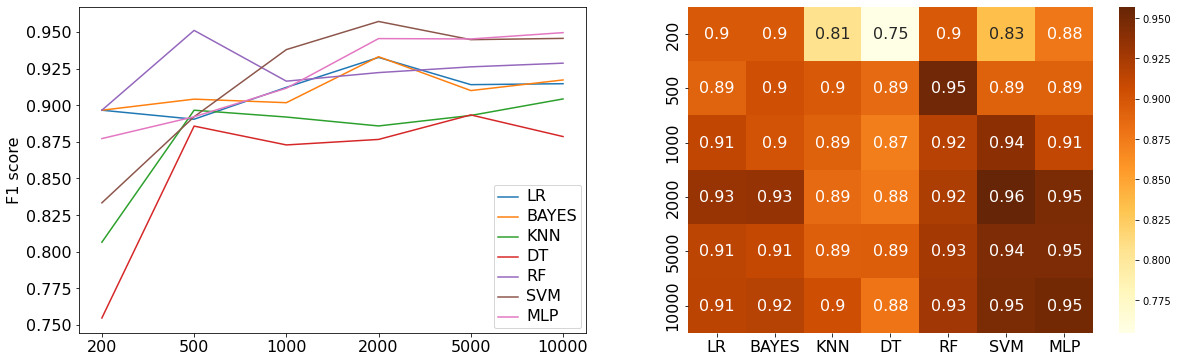

In [46]:
# Line plot + Heatmap of F1 SCORE - Figure for the article

fig = plt.figure(figsize=(20,6))

# Line plot
ax = fig.add_subplot(121)
test_f1_df.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_ylabel('F1 score')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(122)
sns.heatmap(test_f1_df, ax=ax, annot=True, annot_kws={"size": 16}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'F1_over_nsamples_lineplot_heatmap.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

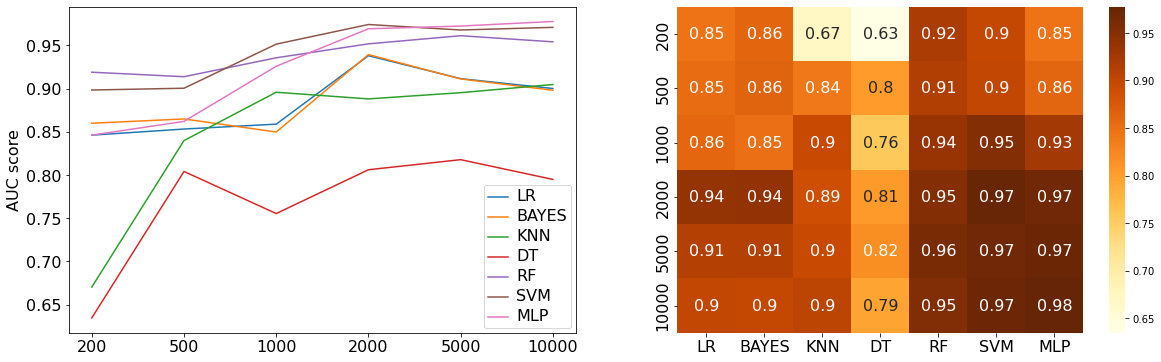

In [47]:
# Line plot + Heatmap of AUC SCORE - Figure for the article

fig = plt.figure(figsize=(20,6))

# Line plot
ax = fig.add_subplot(121)
test_auc_df.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_ylabel('AUC score')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(122)
sns.heatmap(test_auc_df, ax=ax, annot=True, annot_kws={"size": 16}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'AUC_over_nsamples_lineplot_heatmap.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


#### Robustness of classifiers' performance

In [48]:
# For each value of sample size, create a dataframe with the accuracy of each method for each run

nSamples_list = [200, 500, 1000, 2000, 5000, 10000]
train_accuracy_nSample_seeds_list = []
test_accuracy_nSample_seeds_list = []
train_timing_nSample_seeds_list = []
test_timing_nSample_seeds_list = []
train_f1_nSample_seeds_list = []
test_f1_nSample_seeds_list = []
test_auc_nSample_seeds_list = []

for size in nSamples_list:
    temp_nSamples = size
    print("nSamples: ", temp_nSamples)

    # Recover sampling of parameters (X dataset)
    print(nParamsLHS)
    
    np.random.seed(LHS_seed)
    temp_parameters = lhs(nParamsLHS, samples=temp_nSamples, criterion='center')
    temp_parameters_df = pd.DataFrame(temp_parameters)
    temp_parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset']
    
    # Path to the folder of CSV files
    java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\nSamples_' + str(temp_nSamples) + '\\'
    path, dirs, files = next(os.walk(java_folder))
    file_count_seeds = len(files)
    print("Number of files: ", file_count_seeds)
    
    # Create a list of dataframes, one for each csv file
    ABM_prices_df_list = []
    ABM_returns_df_list = []
    
    for i in range(file_count_seeds):
        temp_prices_df = pd.read_csv(java_folder + files[i])
        temp_prices_df = temp_prices_df.drop(['tick'], axis=1)   # Delete column of ticks
        ABM_prices_df_list.append(temp_prices_df)
        
        temp_returns_df = temp_prices_df.pct_change()
        temp_returns_df = temp_returns_df.drop(temp_returns_df.index[0])  # Delete first row (= NaN)
        ABM_returns_df_list.append(temp_returns_df.transpose())
    
    # Extract number of runs and ticks 
    nTicks = ABM_prices_df_list[0].shape[0]
    nRuns = ABM_prices_df_list[0].shape[1]
    print("nTicks:", nTicks)
    print("nRuns:", nRuns)

    # Analyse the stylised facts for each dataframe
    y_list_seeds =  []   # List to store whether stylised facts are satisfied or not (-> y vectors)

    seeds = []
    train_accuracy_list = []
    train_timing_list = []
    test_accuracy_list = []
    test_timing_list = []
    train_f1_list = []
    test_f1_list = []
    test_auc_list = []
    
    for i in range(file_count_seeds):
        # Excess kurtosis of returns
        temp_kurtosis_ret = kurtosis(ABM_returns_df_list[i], axis=1, fisher=True, bias=False)
        
        # Hurst exponent of returns
        Hurst_vector_ret = np.zeros(nRuns)  # Vector to store the Hurst exponent of the different return time series
        for j in range(0, nRuns):
            H = get_hurst_exponent(ABM_prices_df_list[i].iloc[:,j].values, Hurst_max_lag)
            Hurst_vector_ret[j] = H
        temp_Hurst_ret = Hurst_vector_ret
        
        # Engle's ARCH test for volatility
        pval_Lagrange = np.zeros(nRuns)
        for j in range(0, nRuns):
            etest = het_arch(ABM_returns_df_list[i].iloc[j], nlags=5)
            pval_Lagrange[j] = np.round(etest[1], 4)  # Lagrange multiplier test
        temp_ARCH_vol = pval_Lagrange
        
        # Skewness of volatility (=returns^2)
        temp_skewness_vol = skew(pow(ABM_returns_df_list[i],2), axis=1, bias=False)
        
        # Check if stylised facts are satisfied
        SF_satisfied = np.zeros(nRuns, dtype=int)
        for j in range(0, nRuns):
            if (temp_kurtosis_ret[j]>0 and temp_Hurst_ret[j]>0.45 and temp_Hurst_ret[j]<0.55 and temp_ARCH_vol[j]<0.01 and temp_skewness_vol[j]>0):
                SF_satisfied[j] = 1
        
        y_list_seeds.append(SF_satisfied)
        
        # For each seed dataframe, train the ML classifiers and calculate the performance measures
        col_name = "seed" + str(i+1)
        seeds.append(col_name)
        
        # Split X,y into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(temp_parameters_df, y_list_seeds[i], test_size = test_size, random_state = 5)  # Set random state for reproducibility
        
        # Train and test the ML classifiers
        names = []
        train_accuracy = []
        train_timing = []
        test_accuracy = []
        test_timing = []
        train_f1 = []
        test_f1 = []
        test_auc = []
        
        #for name, model in models_tuned:
        for name, model in models_default_params:
            names.append(name)
            # Accuracy for the training data
            start_time = time.perf_counter()
            res = model.fit(X_train, y_train)
            train_result = accuracy_score(res.predict(X_train), y_train)
            train_accuracy.append(train_result)
            end_time = time.perf_counter()
            train_timing.append(end_time-start_time)
            
            # Accuracy for the test data
            start_time = time.perf_counter()
            y_pred = res.predict(X_test)
            test_result = accuracy_score(y_pred, y_test)
            test_accuracy.append(test_result)
            end_time = time.perf_counter()
            test_timing.append(end_time-start_time)
            
            # F1-score
            train_result = f1_score(res.predict(X_train), y_train)
            train_f1.append(train_result)
            test_result = f1_score(y_pred, y_test)
            test_f1.append(test_result)
            
            # AUC score
            res_probs = res.predict_proba(X_test)    # predict probabilities
            res_probs = res_probs[:, 1]   # keep probabilities for the positive outcome only
            test_result = roc_auc_score(y_test, res_probs)
            test_auc.append(test_result)
            
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
        train_timing_list.append(train_timing)
        test_timing_list.append(test_timing)
        train_f1_list.append(train_f1)
        test_f1_list.append(test_f1)
        test_auc_list.append(test_auc)
        
    # Convert lists of performance measures to dataframes
    train_accuracy_df = pd.DataFrame(train_accuracy_list)
    test_accuracy_df = pd.DataFrame(test_accuracy_list)
    train_timing_df = pd.DataFrame(train_timing_list)
    test_timing_df = pd.DataFrame(test_timing_list)
    train_f1_df = pd.DataFrame(train_f1_list)
    test_f1_df = pd.DataFrame(test_f1_list)
    test_auc_df = pd.DataFrame(test_auc_list)
    
    train_accuracy_df.columns = names
    test_accuracy_df.columns = names
    train_timing_df.columns = names
    test_timing_df.columns = names
    train_f1_df.columns = names
    test_f1_df.columns = names
    test_auc_df.columns = names
    
    train_accuracy_nSample_seeds_list.append(train_accuracy_df)
    test_accuracy_nSample_seeds_list.append(test_accuracy_df)
    train_timing_nSample_seeds_list.append(train_timing_df)
    test_timing_nSample_seeds_list.append(test_timing_df)
    train_f1_nSample_seeds_list.append(train_f1_df)
    test_f1_nSample_seeds_list.append(test_f1_df)
    test_auc_nSample_seeds_list.append(test_auc_df)


nSamples:  200
11
       0       1       2       3       4       5       6       7       8   \
0  0.8225  0.3475  0.2125  0.3625  0.9725  0.4625  0.9525  0.9125  0.7325   
1  0.8075  0.3525  0.6975  0.0075  0.9175  0.8275  0.2175  0.5775  0.4425   
2  0.2175  0.6375  0.8825  0.8825  0.2975  0.6625  0.3275  0.9275  0.0475   
3  0.4025  0.5475  0.0775  0.0275  0.6675  0.9925  0.4575  0.6075  0.0225   
4  0.7275  0.8275  0.2275  0.4975  0.7325  0.2575  0.0325  0.8675  0.8225   

       9       10  
0  0.1525  0.8475  
1  0.7825  0.5175  
2  0.8675  0.2875  
3  0.4575  0.1875  
4  0.2575  0.6225  
Number of files:  25
nTicks: 4000
nRuns: 200


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
nSamples:  500
11
      0      1      2      3      4      5      6      7      8      9      10
0  0.245  0.383  0.891  0.007  0.885  0.659  0.075  0.581  0.067  0.781  0.739
1  0.467  0.687  0.075  0.985  0.011  0.789  0.727  0.021  0.275  0.981  0.227
2  0.183  0.987  0.553  0.601  0.177  0.755  0.341  0.063  0.539  0.279  0.497
3  0.133  0.979  0.083  0.525  0.945  0.645  0.875  0.777  0.779  0.103  0.519
4  0.987  0.507  0.415  0.637  0.587  0.529  0.807  0.835  0.889  0.789  0.103
Number of files:  25
nTicks: 4000
nRuns: 500


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
nSamples:  1000
11
       0       1       2       3       4       5       6       7       8   \
0  0.8195  0.9755  0.8185  0.0235  0.1995  0.2725  0.6065  0.9095  0.6065   
1  0.0175  0.1985  0.8225  0.8875  0.5255  0.7635  0.7035  0.3955  0.3825   
2  0.7025  0.8945  0.6355  0.2885  0.2825  0.1665  0.6765  0.1315  0.2985   
3  0.2275  0.4885  0.1345  0.8595  0.5565  0.9625  0.7925  0.0795  0.2815   
4  0.6445  0.2825  0.3485  0.7365  0.2925  0.6635  0.0985  0.1925  0.9805   

       9       10  
0  0.7005  0.6815  
1  0.5265  0.4545  
2  0.2535  0.7185  
3  0.5555  0.9485  
4  0.9085  0.2295  
Number of files:  25
nTicks: 4000
nRuns: 1000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
nSamples:  2000
11
        0        1        2        3        4        5        6        7   \
0  0.32275  0.67425  0.91025  0.07075  0.48475  0.31625  0.01875  0.14675   
1  0.41175  0.49575  0.35825  0.04775  0.29075  0.78875  0.88075  0.15125   
2  0.32825  0.63025  0.28525  0.47375  0.47675  0.37475  0.27125  0.21325   
3  0.94275  0.72475  0.36875  0.12375  0.88775  0.10975  0.94375  0.55925   
4  0.71875  0.96375  0.10575  0.01225  0.83175  0.56875  0.06625  0.28425   

        8        9        10  
0  0.78425  0.10175  0.53975  
1  0.58475  0.72175  0.03675  
2  0.46375  0.32825  0.78675  
3  0.89825  0.70225  0.57075  
4  0.91525  0.60675  0.23025  
Number of files:  25
nTicks: 4000
nRuns: 2000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
nSamples:  5000
11
       0       1       2       3       4       5       6       7       8   \
0  0.4245  0.1793  0.5595  0.3237  0.6251  0.8181  0.0909  0.7759  0.6227   
1  0.6549  0.3211  0.7529  0.7325  0.3875  0.8583  0.1055  0.6177  0.0833   
2  0.4309  0.8829  0.1087  0.0141  0.0197  0.9705  0.1465  0.9859  0.6061   
3  0.9011  0.1155  0.7799  0.7847  0.2015  0.2783  0.3005  0.0887  0.4441   
4  0.1701  0.9897  0.1929  0.1855  0.8963  0.5265  0.6679  0.5521  0.3571   

       9       10  
0  0.2647  0.2667  
1  0.5681  0.0421  
2  0.9395  0.7149  
3  0.3049  0.8337  
4  0.3491  0.2861  
Number of files:  25
nTicks: 4000
nRuns: 5000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
nSamples:  10000
11
        0        1        2        3        4        5        6        7   \
0  0.72985  0.80755  0.91325  0.87155  0.65965  0.14895  0.96665  0.55215   
1  0.64455  0.78775  0.44655  0.42605  0.49055  0.46075  0.35315  0.51675   
2  0.71015  0.65065  0.78355  0.30935  0.76095  0.26315  0.47925  0.37605   
3  0.45345  0.93495  0.88975  0.65605  0.96665  0.84305  0.73385  0.68305   
4  0.93415  0.09925  0.91075  0.64035  0.43375  0.77965  0.74275  0.09545   

        8        9        10  
0  0.21055  0.74465  0.57555  
1  0.22285  0.46725  0.03345  
2  0.48635  0.43325  0.77945  
3  0.45615  0.19555  0.39225  
4  0.96685  0.36055  0.48715  
Number of files:  25
nTicks: 4000
nRuns: 10000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multi

(25, 7)
6


In [49]:
# Calculate the mean and st.dev. of performance measures --> display them in a dataframe

names = []
train_accuracy_mean_list = []
train_accuracy_std_list = []
test_accuracy_mean_list = []
test_accuracy_std_list = []

train_timing_mean_list = []
train_timing_std_list = []
test_timing_mean_list = []
test_timing_std_list = []

train_f1_mean_list = []
train_f1_std_list = []
test_f1_mean_list = []
test_f1_std_list = []

test_auc_mean_list = []
test_auc_std_list = []

#for name, model in models_tuned:
for name, model in models_default_params:
    names.append(name)
    train_accuracy_mean_method_list = []
    train_accuracy_std_method_list = []
    test_accuracy_mean_method_list = []
    test_accuracy_std_method_list = []
    train_timing_mean_method_list = []
    train_timing_std_method_list = []
    test_timing_mean_method_list = []
    test_timing_std_method_list = []
    train_f1_mean_method_list = []
    train_f1_std_method_list = []
    test_f1_mean_method_list = []
    test_f1_std_method_list = []
    test_auc_mean_method_list = []
    test_auc_std_method_list = []
    
    # Calculate the mean over random seeds, for each sample size and method
    for i in range(len(nSamples_list)):  
        # Accuracy for the training data
        mean_result = train_accuracy_nSample_seeds_list[i].mean()[name]
        train_accuracy_mean_method_list.append(mean_result)
        std_result = train_accuracy_nSample_seeds_list[i].std()[name]
        train_accuracy_std_method_list.append(std_result)

        # Accuracy for the test data
        mean_result = test_accuracy_nSample_seeds_list[i].mean()[name]
        test_accuracy_mean_method_list.append(mean_result)
        std_result = test_accuracy_nSample_seeds_list[i].std()[name]
        test_accuracy_std_method_list.append(std_result)

        # Timing for the training data
        mean_result = train_timing_nSample_seeds_list[i].mean()[name]
        train_timing_mean_method_list.append(mean_result)
        std_result = train_timing_nSample_seeds_list[i].std()[name]
        train_timing_std_method_list.append(std_result)

        # Timing for the test data
        mean_result = test_timing_nSample_seeds_list[i].mean()[name]
        test_timing_mean_method_list.append(mean_result)
        std_result = test_timing_nSample_seeds_list[i].std()[name]
        test_timing_std_method_list.append(std_result)

        # F1 score for the training data
        mean_result = train_f1_nSample_seeds_list[i].mean()[name]
        train_f1_mean_method_list.append(mean_result)
        std_result = train_f1_nSample_seeds_list[i].std()[name]
        train_f1_std_method_list.append(std_result)

        # F1 score for the test data
        mean_result = test_f1_nSample_seeds_list[i].mean()[name]
        test_f1_mean_method_list.append(mean_result)
        std_result = test_f1_nSample_seeds_list[i].std()[name]
        test_f1_std_method_list.append(std_result)

        # AUC score for the test data
        mean_result = test_auc_nSample_seeds_list[i].mean()[name]
        test_auc_mean_method_list.append(mean_result)
        std_result = test_auc_nSample_seeds_list[i].std()[name]
        test_auc_std_method_list.append(std_result)
    
    train_accuracy_mean_list.append(train_accuracy_mean_method_list)
    train_accuracy_std_list.append(train_accuracy_std_method_list)
    test_accuracy_mean_list.append(test_accuracy_mean_method_list)
    test_accuracy_std_list.append(test_accuracy_std_method_list)
    train_timing_mean_list.append(train_timing_mean_method_list)
    train_timing_std_list.append(train_timing_std_method_list)
    test_timing_mean_list.append(test_timing_mean_method_list)
    test_timing_std_list.append(test_timing_std_method_list)
    train_f1_mean_list.append(train_f1_mean_method_list)
    train_f1_std_list.append(train_f1_std_method_list)
    test_f1_mean_list.append(test_f1_mean_method_list)
    test_f1_std_list.append(test_f1_std_method_list)
    test_auc_mean_list.append(test_auc_mean_method_list)
    test_auc_std_list.append(test_auc_std_method_list)
    

           
# Convert lists of mean performance measures to dataframes
train_accuracy_mean_df = pd.DataFrame(train_accuracy_mean_list)
train_accuracy_mean_df = train_accuracy_mean_df.transpose()
test_accuracy_mean_df = pd.DataFrame(test_accuracy_mean_list)
test_accuracy_mean_df = test_accuracy_mean_df.transpose()
train_timing_mean_df = pd.DataFrame(train_timing_mean_list)
train_timing_mean_df = train_timing_mean_df.transpose()
test_timing_mean_df = pd.DataFrame(test_timing_mean_list)
test_timing_mean_df = test_timing_mean_df.transpose()
train_f1_mean_df = pd.DataFrame(train_f1_mean_list)
train_f1_mean_df = train_f1_mean_df.transpose()
test_f1_mean_df = pd.DataFrame(test_f1_mean_list)
test_f1_mean_df = test_f1_mean_df.transpose()
test_auc_mean_df = pd.DataFrame(test_auc_mean_list)
test_auc_mean_df = test_auc_mean_df.transpose()

train_accuracy_mean_df.columns = names
test_accuracy_mean_df.columns = names
train_timing_mean_df.columns = names
test_timing_mean_df.columns = names
train_f1_mean_df.columns = names
test_f1_mean_df.columns = names
test_auc_mean_df.columns = names

# Convert lists of standard deviation of performance measures to dataframes
train_accuracy_std_df = pd.DataFrame(train_accuracy_std_list)
train_accuracy_std_df = train_accuracy_std_df.transpose()
test_accuracy_std_df = pd.DataFrame(test_accuracy_std_list)
test_accuracy_std_df = test_accuracy_std_df.transpose()
train_timing_std_df = pd.DataFrame(train_timing_std_list)
train_timing_std_df = train_timing_std_df.transpose()
test_timing_std_df = pd.DataFrame(test_timing_std_list)
test_timing_std_df = test_timing_std_df.transpose()
train_f1_std_df = pd.DataFrame(train_f1_std_list)
train_f1_std_df = train_f1_std_df.transpose()
test_f1_std_df = pd.DataFrame(test_f1_std_list)
test_f1_std_df = test_f1_std_df.transpose()
test_auc_std_df = pd.DataFrame(test_auc_std_list)
test_auc_std_df = test_auc_std_df.transpose()

train_accuracy_std_df.columns = names
test_accuracy_std_df.columns = names
train_timing_std_df.columns = names
test_timing_std_df.columns = names
train_f1_std_df.columns = names
test_f1_std_df.columns = names
test_auc_std_df.columns = names


<Figure size 720x432 with 0 Axes>

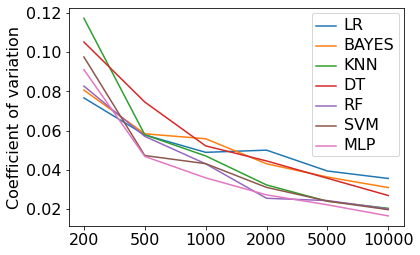

In [50]:
# Coefficient of variation - Figure for the article

# Calculate CV
test_accuracy_cv_df = test_accuracy_std_df/test_accuracy_mean_df

fig = plt.figure(figsize=(10,6))
ax = test_accuracy_cv_df.plot()
x_ticks = range(len(nSamples_list))
x_labels = nSamples_list
ax.set_ylabel('Coefficient of variation')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'coef_variation.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

<Figure size 1440x1440 with 0 Axes>

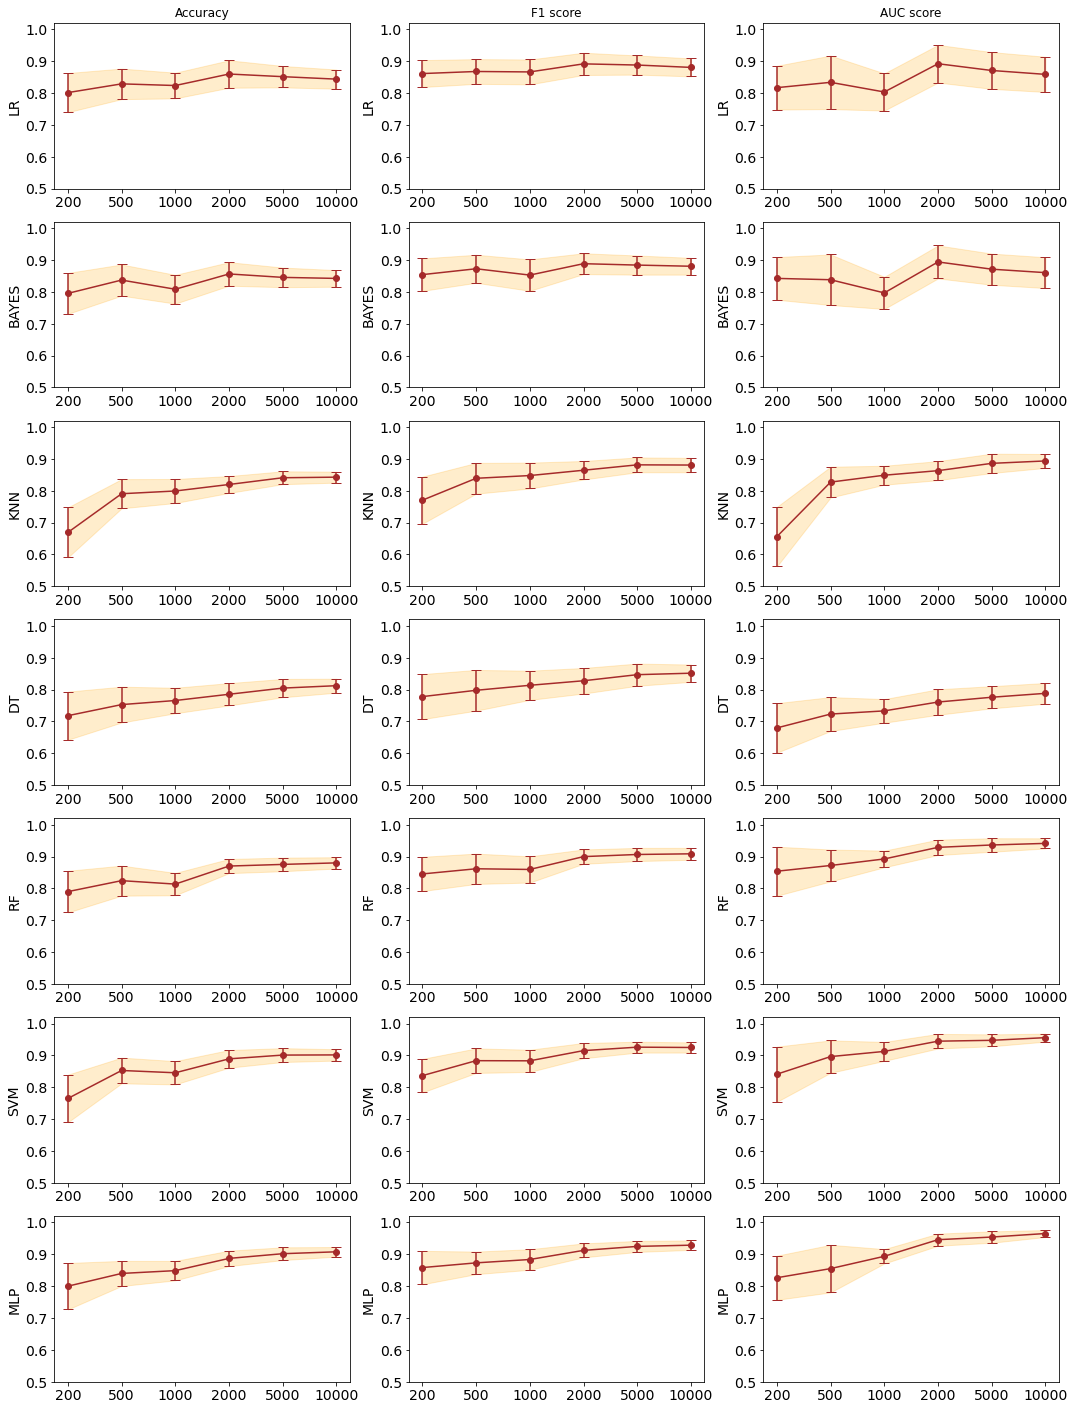

In [52]:
# Robustness over nSamples (error plots) - Figure for the article

fig = plt.figure(figsize=(20,20))

# Plot the channel [mean-2*std, mean+2*std] of performance indicators

# Accuracy and timing
fig, axes = plt.subplots(nrows=len(names), ncols=3, figsize=(18,25))

x_ticks = range(len(nSamples_list))
x_labels = nSamples_list

row = 0
for name in names:
    # Test accuracy (first column)
    lower_threshold_accuracy = test_accuracy_mean_df[name] - 1*test_accuracy_std_df[name]
    upper_threshold_accuracy = test_accuracy_mean_df[name] + 1*test_accuracy_std_df[name]
    
    ax = axes[row,0]
    ax.set_ylim(0.5, 1.02)
    #ax.plot(test_accuracy_mean_df[name], color='brown')
    ax.errorbar(x_ticks, test_accuracy_mean_df[name], yerr=test_accuracy_std_df[name], fmt='-o', color='brown', capsize=5)
    ax.fill_between(x_ticks, lower_threshold_accuracy, upper_threshold_accuracy, color='orange', alpha=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, minor=False, rotation=0)
    ax.set_ylabel(name)
    if row == 0:
        ax.set_title('Accuracy')

    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)   # Increase the font size for better readability in the article

    # Test F1-score (second column)
    lower_threshold_f1 = test_f1_mean_df[name] - 1*test_f1_std_df[name]
    upper_threshold_f1 = test_f1_mean_df[name] + 1*test_f1_std_df[name]
    
    ax = axes[row,1]
    ax.set_ylim(0.5, 1.02)
    #ax.plot(test_f1_mean_df[name], color='brown')
    ax.errorbar(x_ticks, test_f1_mean_df[name], yerr=test_f1_std_df[name], fmt='-o', color='brown', capsize=5)
    ax.fill_between(x_ticks, lower_threshold_f1, upper_threshold_f1, color='orange', alpha=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, minor=False, rotation=0)
    ax.set_ylabel(name)
    if row == 0:
        ax.set_title('F1 score')
    
    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)   # Increase the font size for better readability in the article

    # Testing AUC (third column)
    lower_threshold_auc = test_auc_mean_df[name] - 1*test_auc_std_df[name]
    upper_threshold_auc = test_auc_mean_df[name] + 1*test_auc_std_df[name]
    
    ax = axes[row,2]
    ax.set_ylim(0.5, 1.02)
    #ax.plot(test_auc_mean_df[name], color='brown')
    ax.errorbar(x_ticks, test_auc_mean_df[name], yerr=test_auc_std_df[name], fmt='-o', color='brown', capsize=5)
    ax.fill_between(x_ticks, lower_threshold_auc, upper_threshold_auc, color='orange', alpha=0.2)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, minor=False, rotation=0)
    ax.set_ylabel(name)
    if row == 0:
        ax.set_title('AUC score')

    for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)   # Increase the font size for better readability in the article

    row = row+1

plt.savefig(figures_folder + 'Robustness_over_nsamples.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()


#########################################################################################

### Dealing with randomness of ABM model

#### Averaging the output over a number of ABM runs - Choosing 0-1 labels by majority vote

In [69]:
# For each value of sample size, create an output vector that averages the results over the
# time series obtained from the Java program for different seeds

nSamples_list = [200, 500, 1000, 2000, 5000, 10000]
train_accuracy_avg_list = []
test_accuracy_avg_list = []

for size in nSamples_list:
    temp_nSamples = size
    print("nSamples: ", temp_nSamples)

    # Recover sampling of parameters (X dataset)    
    np.random.seed(LHS_seed)
    temp_parameters = lhs(nParamsLHS, samples=temp_nSamples, criterion='center')
    temp_parameters_df = pd.DataFrame(temp_parameters)
    #print(temp_parameters_df.head())
    temp_parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset']
    
    # Path to the folder of CSV files
    java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\nSamples_' + str(temp_nSamples) + '\\'
    path, dirs, files = next(os.walk(java_folder))
    file_count_seeds = len(files)
    print("Number of files: ", file_count_seeds)
    
    # Create a list of dataframes, one for each csv file
    ABM_prices_df_list = []
    ABM_returns_df_list = []
    
    for i in range(file_count_seeds):
        temp_prices_df = pd.read_csv(java_folder + files[i])
        temp_prices_df = temp_prices_df.drop(['tick'], axis=1)   # Delete column of ticks
        ABM_prices_df_list.append(temp_prices_df)
        
        temp_returns_df = temp_prices_df.pct_change()
        temp_returns_df = temp_returns_df.drop(temp_returns_df.index[0])  # Delete first row (= NaN)
        ABM_returns_df_list.append(temp_returns_df.transpose())
    
    # Extract number of runs and ticks 
    nTicks = ABM_prices_df_list[0].shape[0]
    nRuns = ABM_prices_df_list[0].shape[1]
    print("nTicks:", nTicks)
    print("nRuns:", nRuns)

    # For each run, analyse if each stylised fact is satisfied by majority over random seeds
    kurtosis_ret_majority = []
    Hurst_ret_majority = []
    ARCH_vol_majority = []
    skewness_vol_majority = []
    y_averaged = np.zeros((nRuns,), dtype=int)

    for j in range(nRuns):
        temp_kurtosis_ret_satisfied = []
        temp_Hurst_ret_satisfied = []
        temp_ARCH_vol_satisfied = []
        temp_skewness_vol_satisfied = []

        for i in range(file_count_seeds):
            # Excess kurtosis of returns
            aux_kurt = kurtosis(ABM_returns_df_list[i].iloc[j], fisher=True, bias=False)
            if aux_kurt>0:
                temp_kurtosis_ret_satisfied.append(1)
            else:
                temp_kurtosis_ret_satisfied.append(0)

            # Hurst exponent of returns
            aux_Hurst = get_hurst_exponent(ABM_prices_df_list[i].iloc[:,j].values, Hurst_max_lag)
            if aux_Hurst>0.45 and aux_Hurst<0.55:
                temp_Hurst_ret_satisfied.append(1)
            else:
                temp_Hurst_ret_satisfied.append(0)
            
            # Engle's ARCH test for volatility
            het_arch(ABM_returns_df_list[i].iloc[j], nlags=5)
            aux_pval = np.round(etest[1], 4)
            if aux_pval<0.01:
                temp_ARCH_vol_satisfied.append(1)
            else:
                temp_ARCH_vol_satisfied.append(0)
            
            # Skewness of volatility (=returns^2)
            aux_skew = skew(pow(ABM_returns_df_list[i].iloc[j],2), bias=False)
            if aux_skew>0:
                temp_skewness_vol_satisfied.append(1)
            else:
                temp_skewness_vol_satisfied.append(0)
 
                
        # Check if each sylised fact is satisfied for the majority of seeds or not
        # Excess kurtosis of returns
        if temp_kurtosis_ret_satisfied.count(1) > temp_kurtosis_ret_satisfied.count(0):
            kurtosis_ret_majority.append(1)
        else:
            kurtosis_ret_majority.append(0)
        
        # Hurst exponent of returns
        if temp_Hurst_ret_satisfied.count(1) > temp_Hurst_ret_satisfied.count(0):
            Hurst_ret_majority.append(1)
        else:
            Hurst_ret_majority.append(0)

        # Engle's ARCH test for volatility
        if temp_ARCH_vol_satisfied.count(1) > temp_ARCH_vol_satisfied.count(0):
            ARCH_vol_majority.append(1)
        else:
            ARCH_vol_majority.append(0)

        # Skewness of volatility (=returns^2)
        if temp_skewness_vol_satisfied.count(1) > temp_skewness_vol_satisfied.count(0):
            skewness_vol_majority.append(1)
        else:
            skewness_vol_majority.append(0)
    
        # Calculate the output vector (check if all SF are satisfied at the same time)
        if (kurtosis_ret_majority[j]==1 and Hurst_ret_majority[j]==1 and ARCH_vol_majority[j]==1 and skewness_vol_majority[j]==1):
            y_averaged[j] = 1

    
    # Split X,y into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(temp_parameters_df, y_averaged, test_size = test_size, random_state = 5)  # Set random state for reproducibility
    
    # Train and test the ML classifiers
    names = []
    train_accuracy = []
    test_accuracy = []
    
    #for name, model in models_tuned:
    for name, model in models_default_params:
        names.append(name)
        # Accuracy for the training data
        res = model.fit(X_train, y_train)
        train_result = accuracy_score(res.predict(X_train), y_train)
        train_accuracy.append(train_result)
        
        # Accuracy for the test data
        y_pred = res.predict(X_test)
        test_result = accuracy_score(y_pred, y_test)
        test_accuracy.append(test_result)
            
    train_accuracy_avg_list.append(train_accuracy)
    test_accuracy_avg_list.append(test_accuracy)
    
    

# Convert lists of performance measures to dataframes
train_accuracy_avg_df = pd.DataFrame(train_accuracy_avg_list)
test_accuracy_avg_df = pd.DataFrame(test_accuracy_avg_list)

train_accuracy_avg_df.columns = names        
test_accuracy_avg_df.columns = names

display(train_accuracy_avg_df)
display(test_accuracy_avg_df)      

nSamples:  200
Number of files:  25
nTicks: 4000
nRuns: 200


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


nSamples:  500
Number of files:  25
nTicks: 4000
nRuns: 500


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


nSamples:  1000
Number of files:  25
nTicks: 4000
nRuns: 1000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


nSamples:  2000
Number of files:  25
nTicks: 4000
nRuns: 2000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


nSamples:  5000
Number of files:  25
nTicks: 4000
nRuns: 5000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


nSamples:  10000
Number of files:  25
nTicks: 4000
nRuns: 10000


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.893750,0.881250,0.837500,1.0,1.0,0.943750,0.900000
1,0.857500,0.870000,0.890000,1.0,1.0,0.945000,0.890000
2,0.908750,0.913750,0.895000,1.0,1.0,0.961250,0.936250
3,0.889375,0.885625,0.920000,1.0,1.0,0.956875,0.931875
4,0.893000,0.891000,0.918500,1.0,1.0,0.951500,0.937500
5,0.894375,0.889875,0.921875,1.0,1.0,0.952750,0.950750


,LR,BAYES,KNN,DT,RF,SVM,MLP
0,0.7500,0.750,0.6250,0.6750,0.7500,0.6500,0.7500
1,0.8600,0.910,0.8400,0.8100,0.9000,0.8800,0.8600
2,0.8500,0.860,0.8400,0.8100,0.8800,0.9000,0.8700
3,0.9225,0.920,0.8225,0.8275,0.9100,0.9125,0.9200
4,0.8950,0.881,0.8640,0.8470,0.9060,0.9260,0.9380
5,0.8785,0.876,0.8610,0.8470,0.9085,0.9310,0.9385


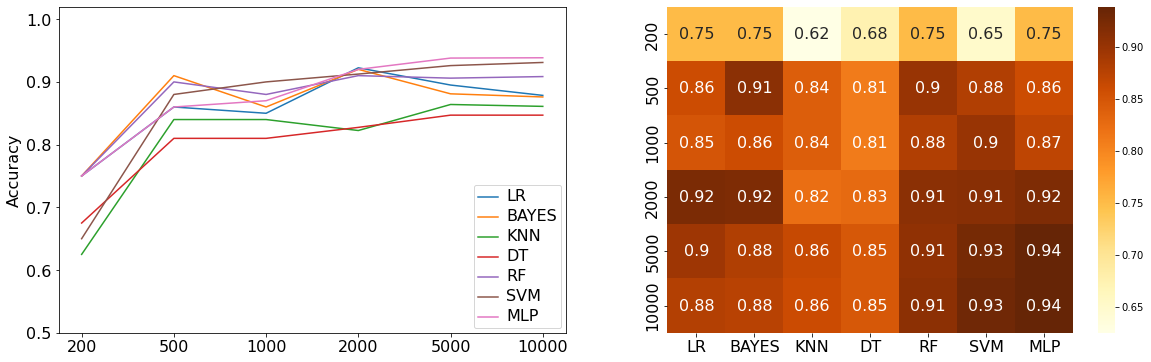

In [70]:
# Line plot + Heatmap of test ACCURACY - Figure for the article

fig = plt.figure(figsize=(20,6))

# Line plot
ax = fig.add_subplot(121)
ax.set_ylim(0.5, 1.02)
test_accuracy_avg_df.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_ylabel('Accuracy')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(122)
sns.heatmap(test_accuracy_avg_df, ax=ax, annot=True, annot_kws={"size": 16}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'accuracy_over_nsamples_lineplot_heatmap_avg_over_seeds.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()

#### Adding the Java random seed as an additional input feature

In [71]:
# Path to the folder of CSV files
java_folder = r'C:\Users\bllac\eclipse-workspace\eclipse_DB\agentsimulator\out\trend-value-var-abm-surrogate\features_plus_random_seed\\'
path, dirs, files = next(os.walk(java_folder))
file_count_samples = len(files)
print(files)

# Create a list of dataframes, one for each csv file
ABM_prices_df_list = []
ABM_returns_df_list = []

for i in range(file_count_samples):
    temp_prices_df = pd.read_csv(java_folder + files[i])
    temp_prices_df = temp_prices_df.drop(['tick'], axis=1)   # Delete column of ticks
    ABM_prices_df_list.append(temp_prices_df)

    temp_returns_df = temp_prices_df.pct_change()
    temp_returns_df = temp_returns_df.drop(temp_returns_df.index[0])  # Delete first row (= NaN)
    ABM_returns_df_list.append(temp_returns_df.transpose())


['java_price_timeseries_12_00200.csv', 'java_price_timeseries_12_00500.csv', 'java_price_timeseries_12_01000.csv', 'java_price_timeseries_12_02000.csv', 'java_price_timeseries_12_05000.csv', 'java_price_timeseries_12_10000.csv']


In [72]:
# Analyse the stylised facts for each dataframe
y_list_samples = []   # List to store whether stylised facts are satisfied or not (-> y vectors)

for i in range(file_count_samples):
    # Extract number of runs and ticks 
    nTicks = ABM_prices_df_list[i].shape[0]
    nRuns = ABM_prices_df_list[i].shape[1]
    
    # Excess kurtosis of returns
    temp_kurtosis_ret = kurtosis(ABM_returns_df_list[i], axis=1, fisher=True, bias=False)

    # Hurst exponent of returns
    Hurst_vector_ret = np.zeros(nRuns)  # Vector to store the Hurst exponent of the different return time series
    for j in range(0, nRuns):
        H = get_hurst_exponent(ABM_prices_df_list[i].iloc[:,j].values, Hurst_max_lag)
        Hurst_vector_ret[j] = H
    temp_Hurst_ret = Hurst_vector_ret

    # Engle's ARCH test for volatility
    pval_Lagrange = np.zeros(nRuns)
    for j in range(0, nRuns):
        etest = het_arch(ABM_returns_df_list[i].iloc[j], nlags=5)
        pval_Lagrange[j] = np.round(etest[1], 4)  # Lagrange multiplier test
    temp_ARCH_vol = pval_Lagrange

    # Skewness of volatility (=returns^2)
    temp_skewness_vol = skew(pow(ABM_returns_df_list[i],2), axis=1, bias=False)

    # Check if stylised facts are satisfied
    SF_satisfied = np.zeros(nRuns, dtype=int)
    for j in range(0, nRuns):
    	if (temp_kurtosis_ret[j]>0 and temp_Hurst_ret[j]>0.45 and temp_Hurst_ret[j]<0.55 and temp_ARCH_vol[j]<0.01 and temp_skewness_vol[j]>0):
            SF_satisfied[j] = 1
    
    y_list_samples.append(SF_satisfied)


nTicks: 4000
nRuns: 200
nTicks: 4000
nRuns: 500
nTicks: 4000
nRuns: 1000
nTicks: 4000
nRuns: 2000
nTicks: 4000
nRuns: 5000
nTicks: 4000
nRuns: 10000


In [73]:
# For each dataframe, train the ML classifiers and calculate the performance measures
labels_nSamples = []
train_accuracy_list_12 = []
test_accuracy_list_12 = []

for i in range(file_count_samples):
    col_name = "nSample_" + str(ABM_prices_df_list[i].shape[1])   # nRuns
    labels_nSamples.append(col_name)

    # Recover sampling of parameters (X dataset)
    nParamsLHS_plus_seed = nParamsLHS + 1   # The random seed is now an additional input feature
    np.random.seed(LHS_seed)
    temp_parameters = lhs(nParamsLHS_plus_seed, samples=ABM_prices_df_list[i].shape[1], criterion='center')
    temp_parameters_df = pd.DataFrame(temp_parameters)
    temp_parameters_df.columns = ['nTrends', 'nFunds', 'liq', 'sigma_P', 'sigma_V', 'maShortMin', 'maLongMin', 'bcTicksMin', 'entryThMin', 'exitThdMin', 'valueOffset', 'startSeed']

    # Split X,y into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(temp_parameters_df, y_list_samples[i], test_size = test_size, random_state = 5)  # Set random state for reproducibility
    
    # Train and test the ML classifiers
    names = []
    train_accuracy = []
    test_accuracy = []
   
    #for name, model in models_tuned:
    for name, model in models_default_params:
        names.append(name)
        # Accuracy for the training data
        res = model.fit(X_train, y_train)
        train_result = accuracy_score(res.predict(X_train), y_train)
        train_accuracy.append(train_result)
            
        # Accuracy for the test data
        y_pred = res.predict(X_test)
        test_result = accuracy_score(y_pred, y_test)
        test_accuracy.append(test_result)
        
    train_accuracy_list_12.append(train_accuracy)
    test_accuracy_list_12.append(test_accuracy)
        

# Convert lists of performance measures to dataframes
train_accuracy_df_12 = pd.DataFrame(train_accuracy_list_12)
test_accuracy_df_12 = pd.DataFrame(test_accuracy_list_12)

train_accuracy_df_12.columns = names        
test_accuracy_df_12.columns = names


['nSample_200']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000', 'nSample_5000']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['nSample_200', 'nSample_500', 'nSample_1000', 'nSample_2000', 'nSample_5000', 'nSample_10000']
12


c:\Users\bllac\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


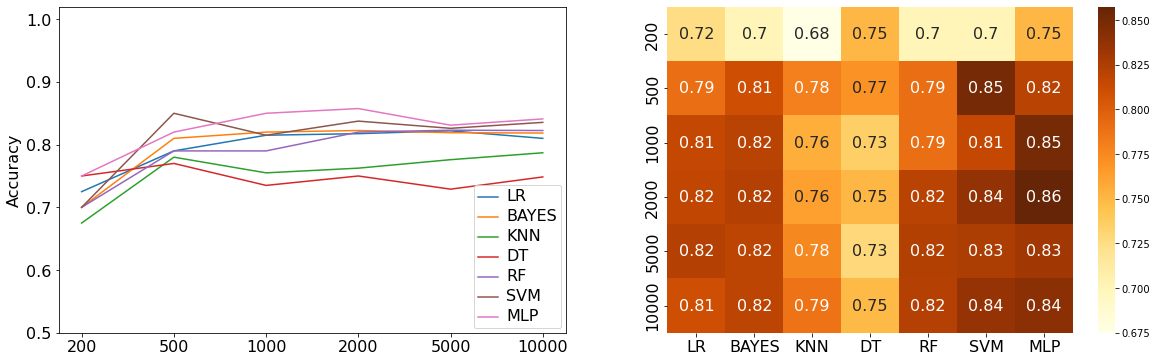

In [74]:
# Line plot + Heatmap of test ACCURACY - Figure for the article

fig = plt.figure(figsize=(20,6))

# Line plot
ax = fig.add_subplot(121)
ax.set_ylim(0.5, 1.02)
test_accuracy_df_12.plot(ax=ax)
x_ticks = range(file_count_samples)
#x_labels = labels_nSamples
x_labels = ['200', '500', '1000', '2000', '5000', '10000']
ax.set_ylabel('Accuracy')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_labels, minor=False, rotation=0)
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

ax = fig.add_subplot(122)
sns.heatmap(test_accuracy_df_12, ax=ax, annot=True, annot_kws={"size": 16}, cmap="YlOrBr", yticklabels=['200', '500', '1000', '2000', '5000', '10000'])
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)   # Increase the font size for better readability in the article

plt.savefig(figures_folder + 'accuracy_over_nsamples_lineplot_heatmap_12features.png', bbox_inches = 'tight')   # Save figure for the article
plt.show()
